We first clone and install the required packages to make sure of reproducibility of the code

In [ ]:
!git clone https://github.com/MarioHabibFathi/Machine-Learning-Hand-Gestures-Project.git

%cd Machine-Learning-Hand-Gestures-Project

In [ ]:
# Install the dependencies from the requirements.txt to ensure reproducibility
!pip install -r requirements.txt

We import the necessary packges that we will use throught this notebook

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from scipy.stats import loguniform
from scipy import stats
import time
import tracemalloc
import psutil
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
import cv2
from collections import deque
#If we want to connect our notebook to colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
num_points = 21
seed = 42

# Data Loading

We load the data from github using wget into colab then into our notebook 

In [3]:
df = pd.read_csv('hand_landmarks_data.csv')

We do a few data exploratory analysis to know the type of data and find if there any NANs and what reltions we can come up with

In [4]:
df.shape

(25675, 64)

In [5]:
df.head()

x1          y1            z1          x2          y2        z2  \
0  262.669968  257.304901 -3.649205e-07  257.417542  247.109055  0.004224   
1   83.351778  346.059113 -2.345265e-07   81.925037  328.562347 -0.011102   
2  187.756977  260.235492 -2.417307e-07  195.460579  241.506035 -0.000184   
3  114.976696  331.594238 -1.233261e-07  114.503494  320.549957 -0.002824   
4  188.795288  141.727867 -1.622995e-07  188.520905  127.947464 -0.002884   

           x3          y3        z3          x4  ...         x19         y19  \
0  246.882957  241.716827  0.005798  236.384537  ...  223.345093  255.490692   
1   90.080132  311.535248 -0.021096   95.641823  ...  132.451618  341.794434   
2  207.259529  223.674339 -0.009687  215.413628  ...  250.301010  268.602938   
3  116.636627  310.080994 -0.008911  117.685066  ...  145.195450  329.357544   
4  191.982880  111.010563 -0.008115  192.552521  ...  226.696396  132.263248   

        z19         x20         y20       z20         x21         y21  \
0 -0.020450  215.043365  258.114746 -0.024577  208.006393  259.608673   
1 -0.038175  142.773582  342.829254 -0.037336  152.431698  343.015991   
2 -0.044068  262.425133  271.276638 -0.040469  272.989952  272.272231   
3 -0.027622  151.053200  329.712341 -0.027863  155.990364  329.548828   
4 -0.025113  234.831741  130.684147 -0.024087  241.587769  128.477188   

        z21  label  
0 -0.026722   call  
1 -0.036136   call  
2 -0.038301   call  
3 -0.027723   call  
4 -0.023486   call  

[5 rows x 64 columns]

In [6]:
df.columns

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8',
       'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12',
       'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15',
       'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18',
       'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'x21', 'y21', 'z21', 'label'],
      dtype='object')

We find if there was any missing values

In [7]:
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

We drop the z columns since it would not be any benefical to us and find the new shape 

In [9]:
df = df.drop(['z'+str(x) for x in range(1,22)], axis=1)
df.head()

x1          y1          x2          y2          x3          y3  \
0  262.669968  257.304901  257.417542  247.109055  246.882957  241.716827   
1   83.351778  346.059113   81.925037  328.562347   90.080132  311.535248   
2  187.756977  260.235492  195.460579  241.506035  207.259529  223.674339   
3  114.976696  331.594238  114.503494  320.549957  116.636627  310.080994   
4  188.795288  141.727867  188.520905  127.947464  191.982880  111.010563   

           x4          y4          x5          y5  ...         y17  \
0  236.384537  241.453918  230.076668  243.947525  ...  268.069519   
1   95.641823  298.860626   94.470360  287.298767  ...  336.647949   
2  215.413628  209.035360  214.772873  196.609588  ...  264.505473   
3  117.685066  301.874115  116.766609  294.977814  ...  324.407806   
4  192.552521   98.687691  188.239563   90.394289  ...  131.502628   

          x18         y18         x19         y19         x20         y20  \
0  236.512527  251.706177  223.345093  255.490692  215.043365  258.114746   
1  116.245079  341.947784  132.451618  341.794434  142.773582  342.829254   
2  230.100174  265.584175  250.301010  268.602938  262.425133  271.276638   
3  135.485836  329.050110  145.195450  329.357544  151.053200  329.712341   
4  213.105820  135.293209  226.696396  132.263248  234.831741  130.684147   

          x21         y21  label  
0  208.006393  259.608673   call  
1  152.431698  343.015991   call  
2  272.989952  272.272231   call  
3  155.990364  329.548828   call  
4  241.587769  128.477188   call  

[5 rows x 43 columns]

In [10]:
df.columns

Index(['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6',
       'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11', 'y11', 'x12',
       'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16', 'y16', 'x17',
       'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21', 'y21', 'label'],
      dtype='object')

In [11]:
df.shape

(25675, 43)

We find if the name of the lables and find if the counts of each of them to dtermine if it was a balanced problem or not 

In [12]:
labels_unique = df['label'].unique()
labels_unique

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
       'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
       'three', 'three2', 'two_up', 'two_up_inverted'], dtype=object)

In [13]:
df['label'].value_counts()

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64

We discovered that it is a bit imbalanced dataset, but we can deal with it as it is

# Data Visualization

Now we do a bit of data visualization to discover our data and how it looks like

First we visualize a single sample from the palm label to see how it looks like and create a connection dictinary to draw the hand skeleton

In [14]:
result = df[df.iloc[:, -1] == 'palm'].iloc[0]
x_value_0 = result.iloc[[x for x in range(0,42,2)]].values.astype(float)
y_value_0 = result.iloc[[x for x in range(1,42,2)]].values.astype(float)
label_0 = result.iloc[-1]

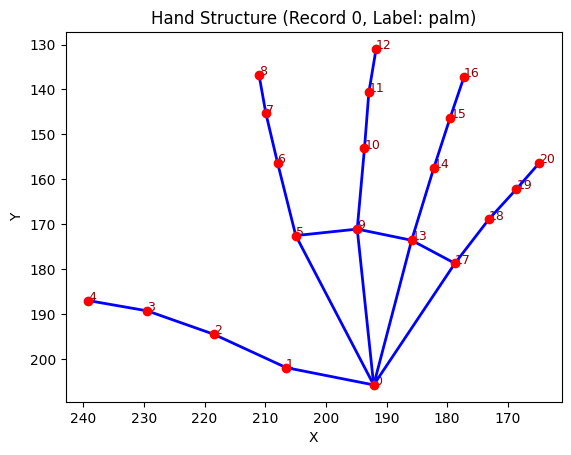

In [15]:
plt.scatter(x_value_0, y_value_0, color='red', zorder=5)

for i, (x, y) in enumerate(zip(x_value_0, y_value_0)):
    plt.text(x, y, f'{i}', fontsize=9, color='darkred')

connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),         
    (0, 5), (5, 6), (6, 7), (7, 8),       
    (0, 9), (9, 10), (10, 11), (11, 12),   
    (0, 13), (13, 14), (14, 15), (15, 16), 
    (0, 17), (17, 18), (18, 19), (19, 20),  
    (5, 9), (9, 13), (13, 17)
]

for (i, j) in connections:
    if i < len(x_value_0) and j < len(x_value_0):
        plt.plot([x_value_0[i], x_value_0[j]], [y_value_0[i], y_value_0[j]],
                 'b-', linewidth=2, zorder=3)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Hand Structure (Record 0, Label: {label_0})")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()


Now we generalize the graph to be able to visualize all the different labels

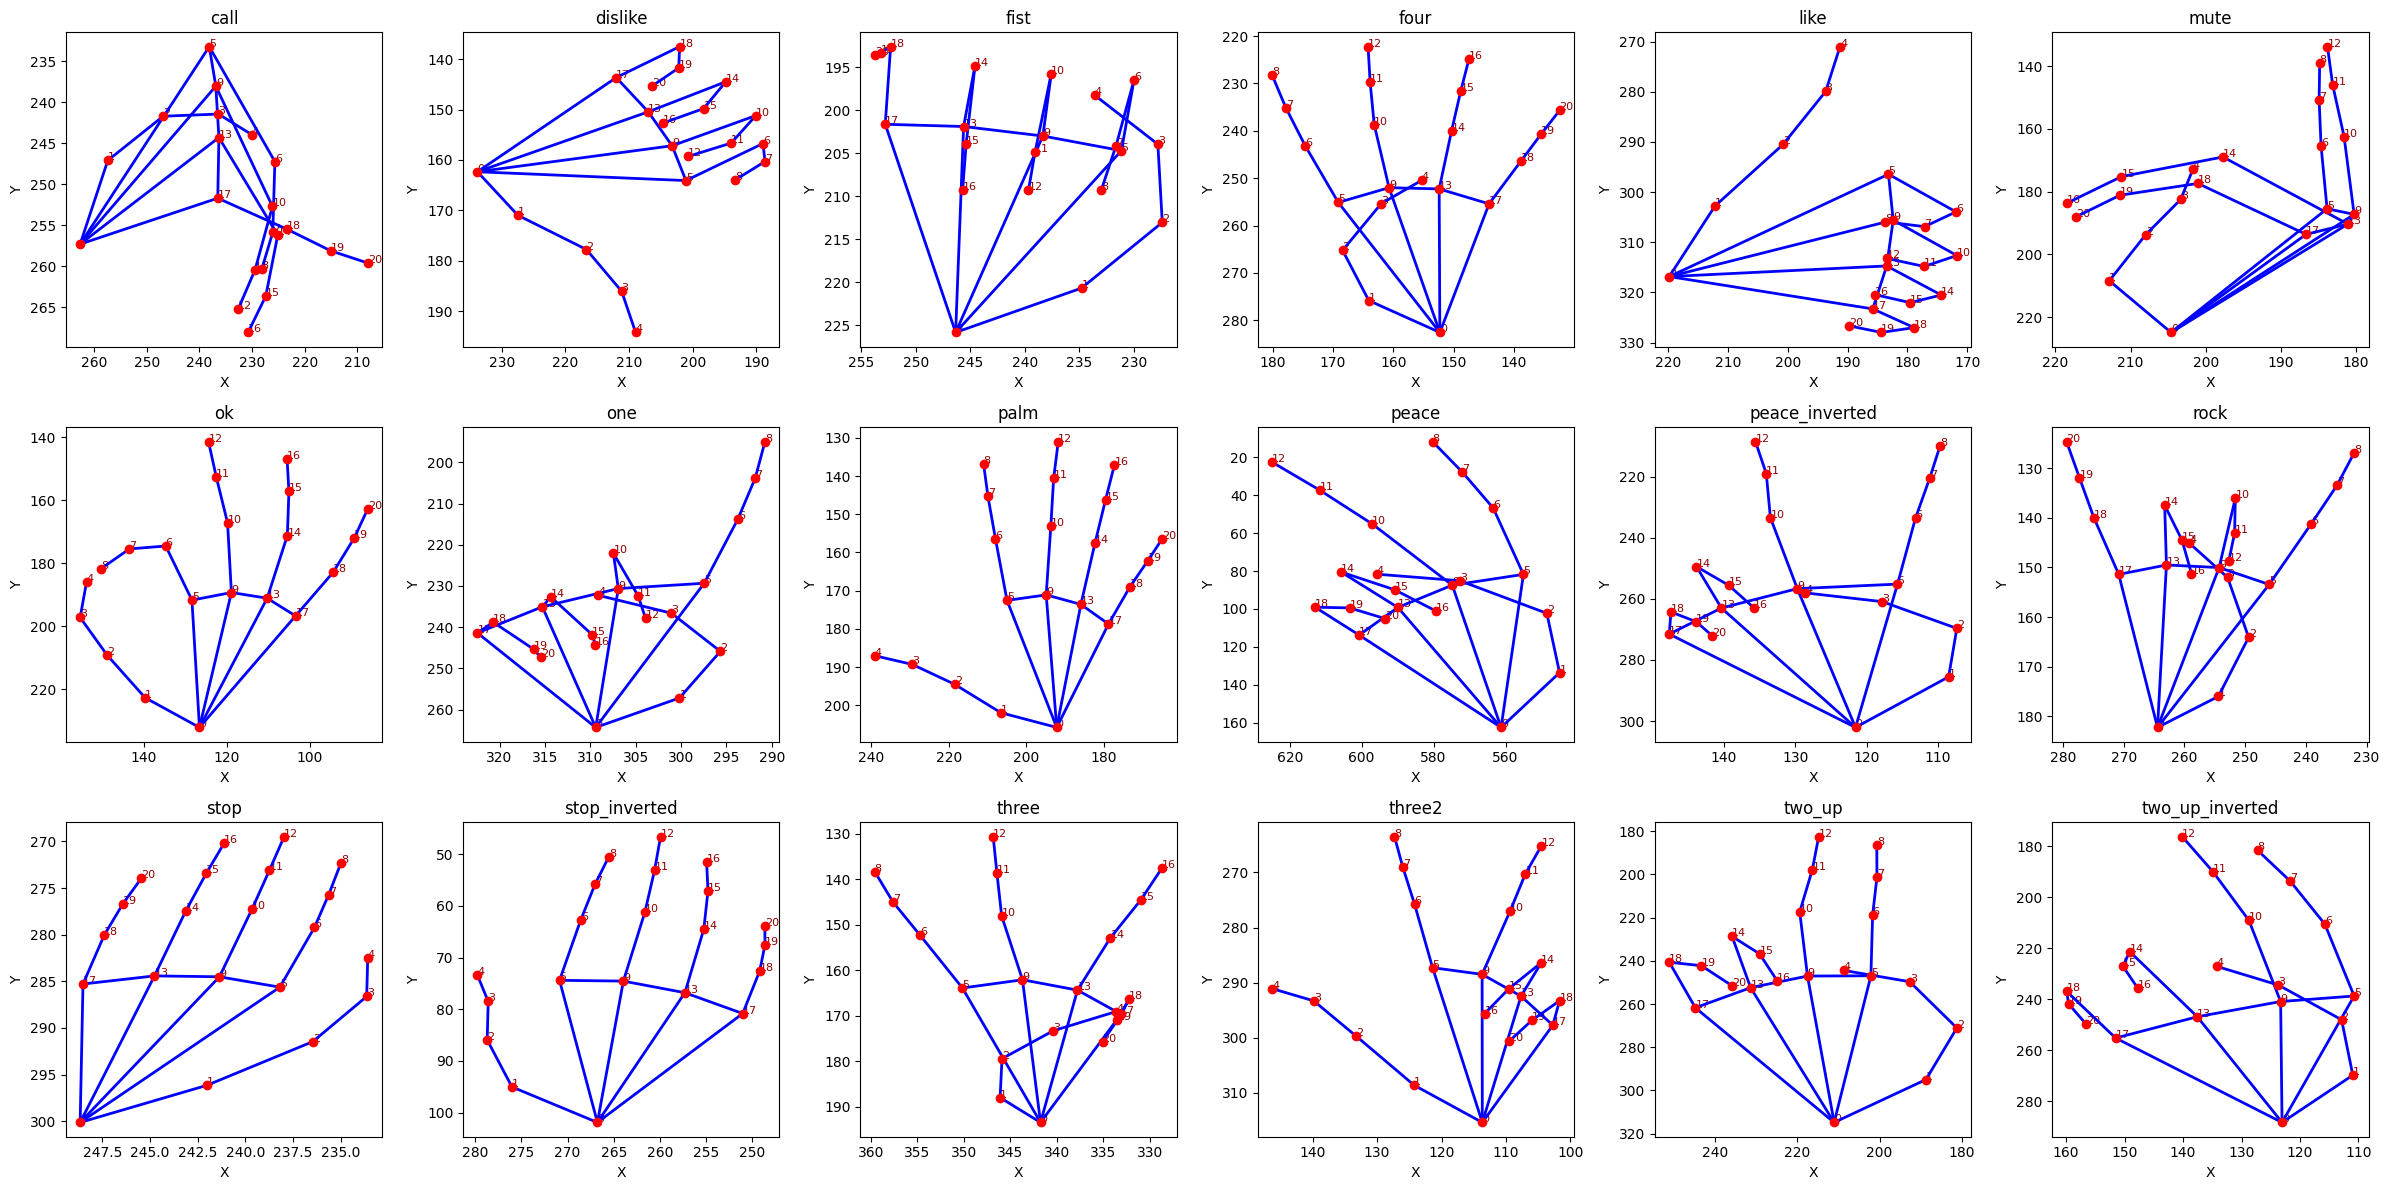

In [16]:
num_plots = len(labels_unique)
ncols = 6
nrows = (num_plots + ncols - 1) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axs = axs.flatten()

for ax, label in zip(axs, labels_unique):

    result = df[df.iloc[:, -1] == label].iloc[0]
    x_value = result.iloc[[i for i in range(0, 42, 2)]].values.astype(float)
    y_value = result.iloc[[i for i in range(1, 42, 2)]].values.astype(float)
    ax.scatter(x_value, y_value, color='red', zorder=5)


    for i, (x, y) in enumerate(zip(x_value, y_value)):
        ax.text(x, y, str(i), fontsize=8, color='darkred')
    for (i, j) in connections:
        if i < len(x_value) and j < len(x_value):
            ax.plot([x_value[i], x_value[j]], [y_value[i], y_value[j]],
                    'b-', linewidth=2, zorder=3)

    ax.set_title(label)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.invert_xaxis()

for i in range(len(labels_unique), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


Now we try to visualize and find if there was any correlation between the set of points

We do it by calculating the euclidean distances as a part of feature engineering two combine two points and the default point is the palm with index 1

In [17]:
def compute_distance_corr(df, num_points=21, palm_idx=1):
    """
    Computes and returns the correlation matrix based on Euclidean distances
    of each hand landmark from the palm (wrist).

    Parameters:
      df : DataFrame
          Preprocessed DataFrame with columns 'x1', 'y1', ..., 'x{num_points}', 'y{num_points}'.
      num_points : int, optional
          Number of landmarks (default is 21).
      palm_idx : int, optional
          Index of the palm landmark (default is 1, i.e. x1, y1).

    Returns:
      corr_matrix : DataFrame
          Correlation matrix computed on the 21 distance features.
    """
    palm_x = df[f'x{palm_idx}']
    palm_y = df[f'y{palm_idx}']
    df_temp = df.copy()
    for i in range(1, num_points + 1):
        df_temp[f'pt{i}_dist'] = np.sqrt((df_temp[f'x{i}'] - palm_x)**2 + (df_temp[f'y{i}'] - palm_y)**2)

    dist_columns = [f'pt{i}_dist' for i in range(1, num_points + 1)]
    df_dist = df_temp[dist_columns]
    corr_matrix = df_dist.corr()
    return corr_matrix

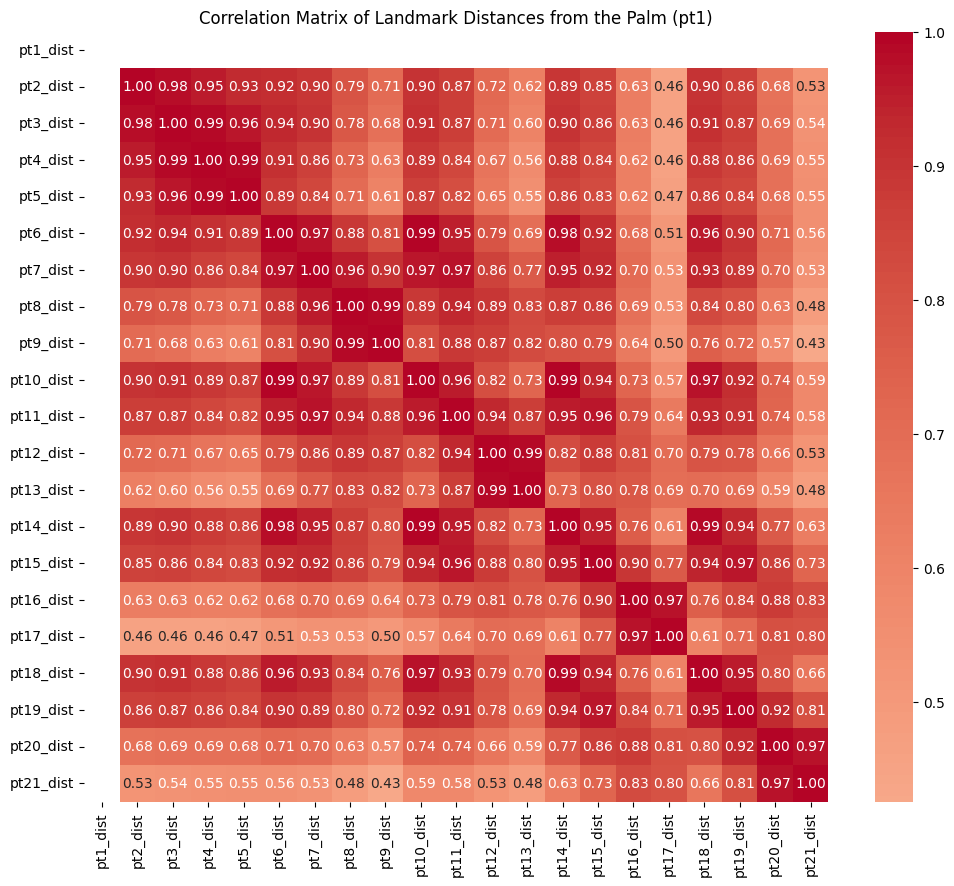

In [18]:
corr_matrix = compute_distance_corr(df, num_points=num_points, palm_idx=1)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from the Palm (pt1)")
plt.show()

We also try to find the correlation between all the point and the tip of the middle index finger

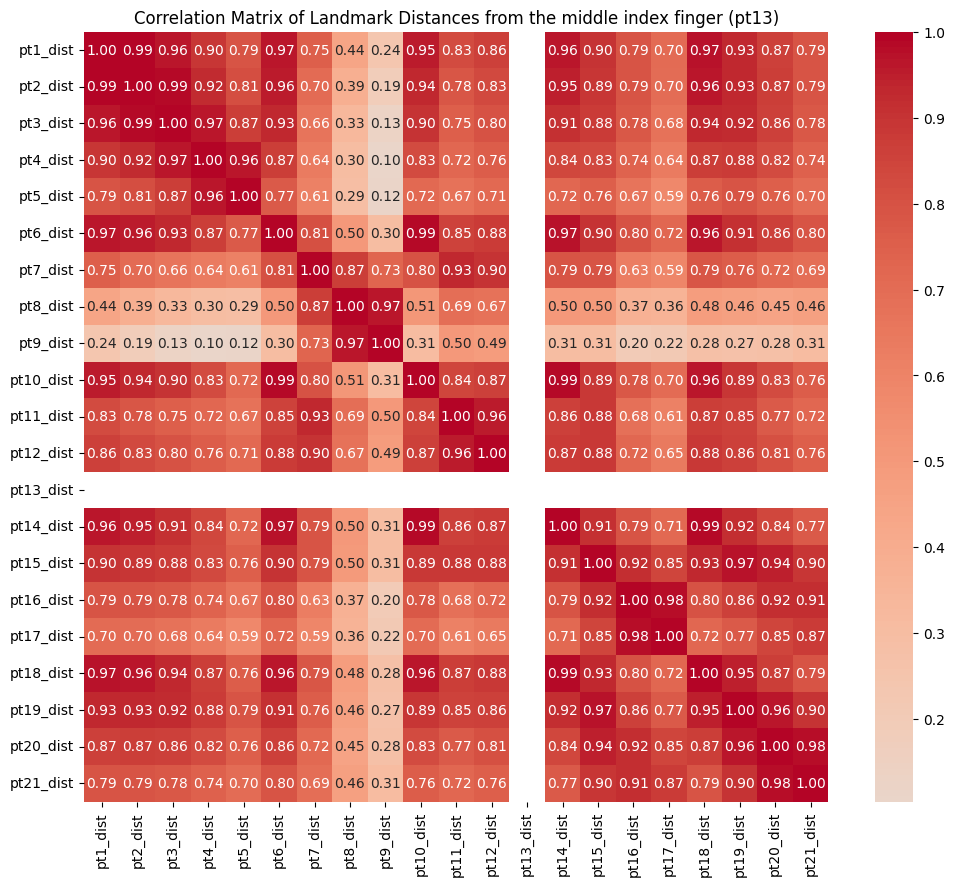

In [19]:
corr_matrix = compute_distance_corr(df, num_points=num_points, palm_idx=13)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from the middle index finger (pt13)")
plt.show()

From both correlations, we can see that some points have a high correlations above the 0.98, which can be utilized to help in the training of the model

# Data Preprocessing

We do now a small task of data preprocessing where we first normalize the coordinates by image resolution, after, we recenter the data along the palm coordinates (x1,y1) and then we scale it by calculating the euclidean distance to the middle index finger tip (x13,y13)

Also, here we divide the dataset into a train set and a test set, with a seed of 42 to ensure the reproducibility.

In [20]:
def preprocess_hand_landmarks(df, img_width=1920, img_height=1080, num_points=21, palm_idx=1, index_tip_idx=13):
    """
    Preprocess hand landmarks:
      1. Normalize coordinates by image resolution.
      2. Recenter coordinates so that the palm (x1,y1) becomes (0,0).
      3. Scale coordinates using the Euclidean distance from palm to middle finger tip (x13,y13).
    """
    df_new = df.copy()
    for i in range(1, num_points+1):
        df_new[f'x{i}'] = df_new[f'x{i}'] / img_width
        df_new[f'y{i}'] = df_new[f'y{i}'] / img_height

    palm_x = df_new[f'x{palm_idx}'].copy()
    palm_y = df_new[f'y{palm_idx}'].copy()
    for i in range(1, num_points+1):
        df_new[f'x{i}'] = df_new[f'x{i}'] - palm_x
        df_new[f'y{i}'] = df_new[f'y{i}'] - palm_y
        
    scale = np.sqrt(df_new[f'x{index_tip_idx}']**2 + df_new[f'y{index_tip_idx}']**2) + 1e-8
    for i in range(1, num_points+1):
        df_new[f'x{i}'] = df_new[f'x{i}'] / scale
        df_new[f'y{i}'] = df_new[f'y{i}'] / scale    
    
    return df_new



def compute_distance_features(df, num_points=21, palm_idx=1):
    """
    For a DataFrame with columns x1, y1, ... x{num_points}, y{num_points},
    compute Euclidean distances from the palm (landmark with index palm_idx)
    and return a new DataFrame with columns: pt1_dist, pt2_dist, ..., pt{num_points}_dist.
    """
    df_dist = df.copy()
    palm_x = df_dist[f'x{palm_idx}']
    palm_y = df_dist[f'y{palm_idx}']

    for i in range(1, num_points+1):
        df_dist[f'pt{i}_dist'] = np.sqrt((df_dist[f'x{i}'] - palm_x)**2 +
                                         (df_dist[f'y{i}'] - palm_y)**2)
    dist_columns = [f'pt{i}_dist' for i in range(1, num_points+1)]
    return df_dist[dist_columns]

def drop_highly_correlated_features(df_dist, threshold=0.99):
    """
    Given a DataFrame of distance features, compute its absolute correlation matrix,
    then iterate through the columns in order. For each new column, if it is highly 
    correlated (>= threshold) with any previously encountered (kept) column, print a 
    message and mark it for dropping.
    
    Returns:
      to_drop : List of feature names (distance columns) to drop.
      corr_matrix : The absolute correlation matrix of df_dist.
    """
    corr_matrix = df_dist.corr().abs()
    kept = []
    to_drop = []
    
    for col in df_dist.columns:
        drop_flag = False
        for kept_col in kept:
            if corr_matrix.loc[col, kept_col] >= threshold:
                print(f"{col} is correlated with {kept_col} (correlation = {corr_matrix.loc[col, kept_col]:.4f}). Dropping {col}.")
                drop_flag = True
                to_drop.append(col)
                break
        if not drop_flag:
            kept.append(col)
    
    return to_drop, corr_matrix

def drop_landmarks_from_data(df_raw, to_drop):
    """
    Given a raw DataFrame with columns x{i} and y{i}, drop the columns corresponding 
    to each distance feature in the to_drop list (e.g., if 'pt5_dist' is in to_drop, drop x5 and y5).
    """
    df_new = df_raw.copy()
    for dist_col in to_drop:
        i = int(dist_col.replace('pt', '').replace('_dist', ''))
        for col in [f'x{i}', f'y{i}']:
            if col in df_new.columns:
                df_new.drop(columns=col, inplace=True)
    distance_cols = [f'pt{i}_dist' for i in range(1, num_points+1)]
    df_new.drop(columns=[col for col in distance_cols if col in df_new.columns], inplace=True)
    return df_new



We first do a label encoding to the features to be able to pass them as the labels for the machine learning model

In [21]:
le = LabelEncoder()
labels = le.fit_transform(df['label'])

df_preprocessed = preprocess_hand_landmarks(df, img_width=1920, img_height=1080, num_points=num_points, palm_idx=1, index_tip_idx=13)
df_preprocessed = df_preprocessed.drop(columns=['label'])
df_raw = df.drop(columns=['label'])

To verify that our preprocessing was correct, we will revisualize the graph to make sure that nothing has changed and it is the same

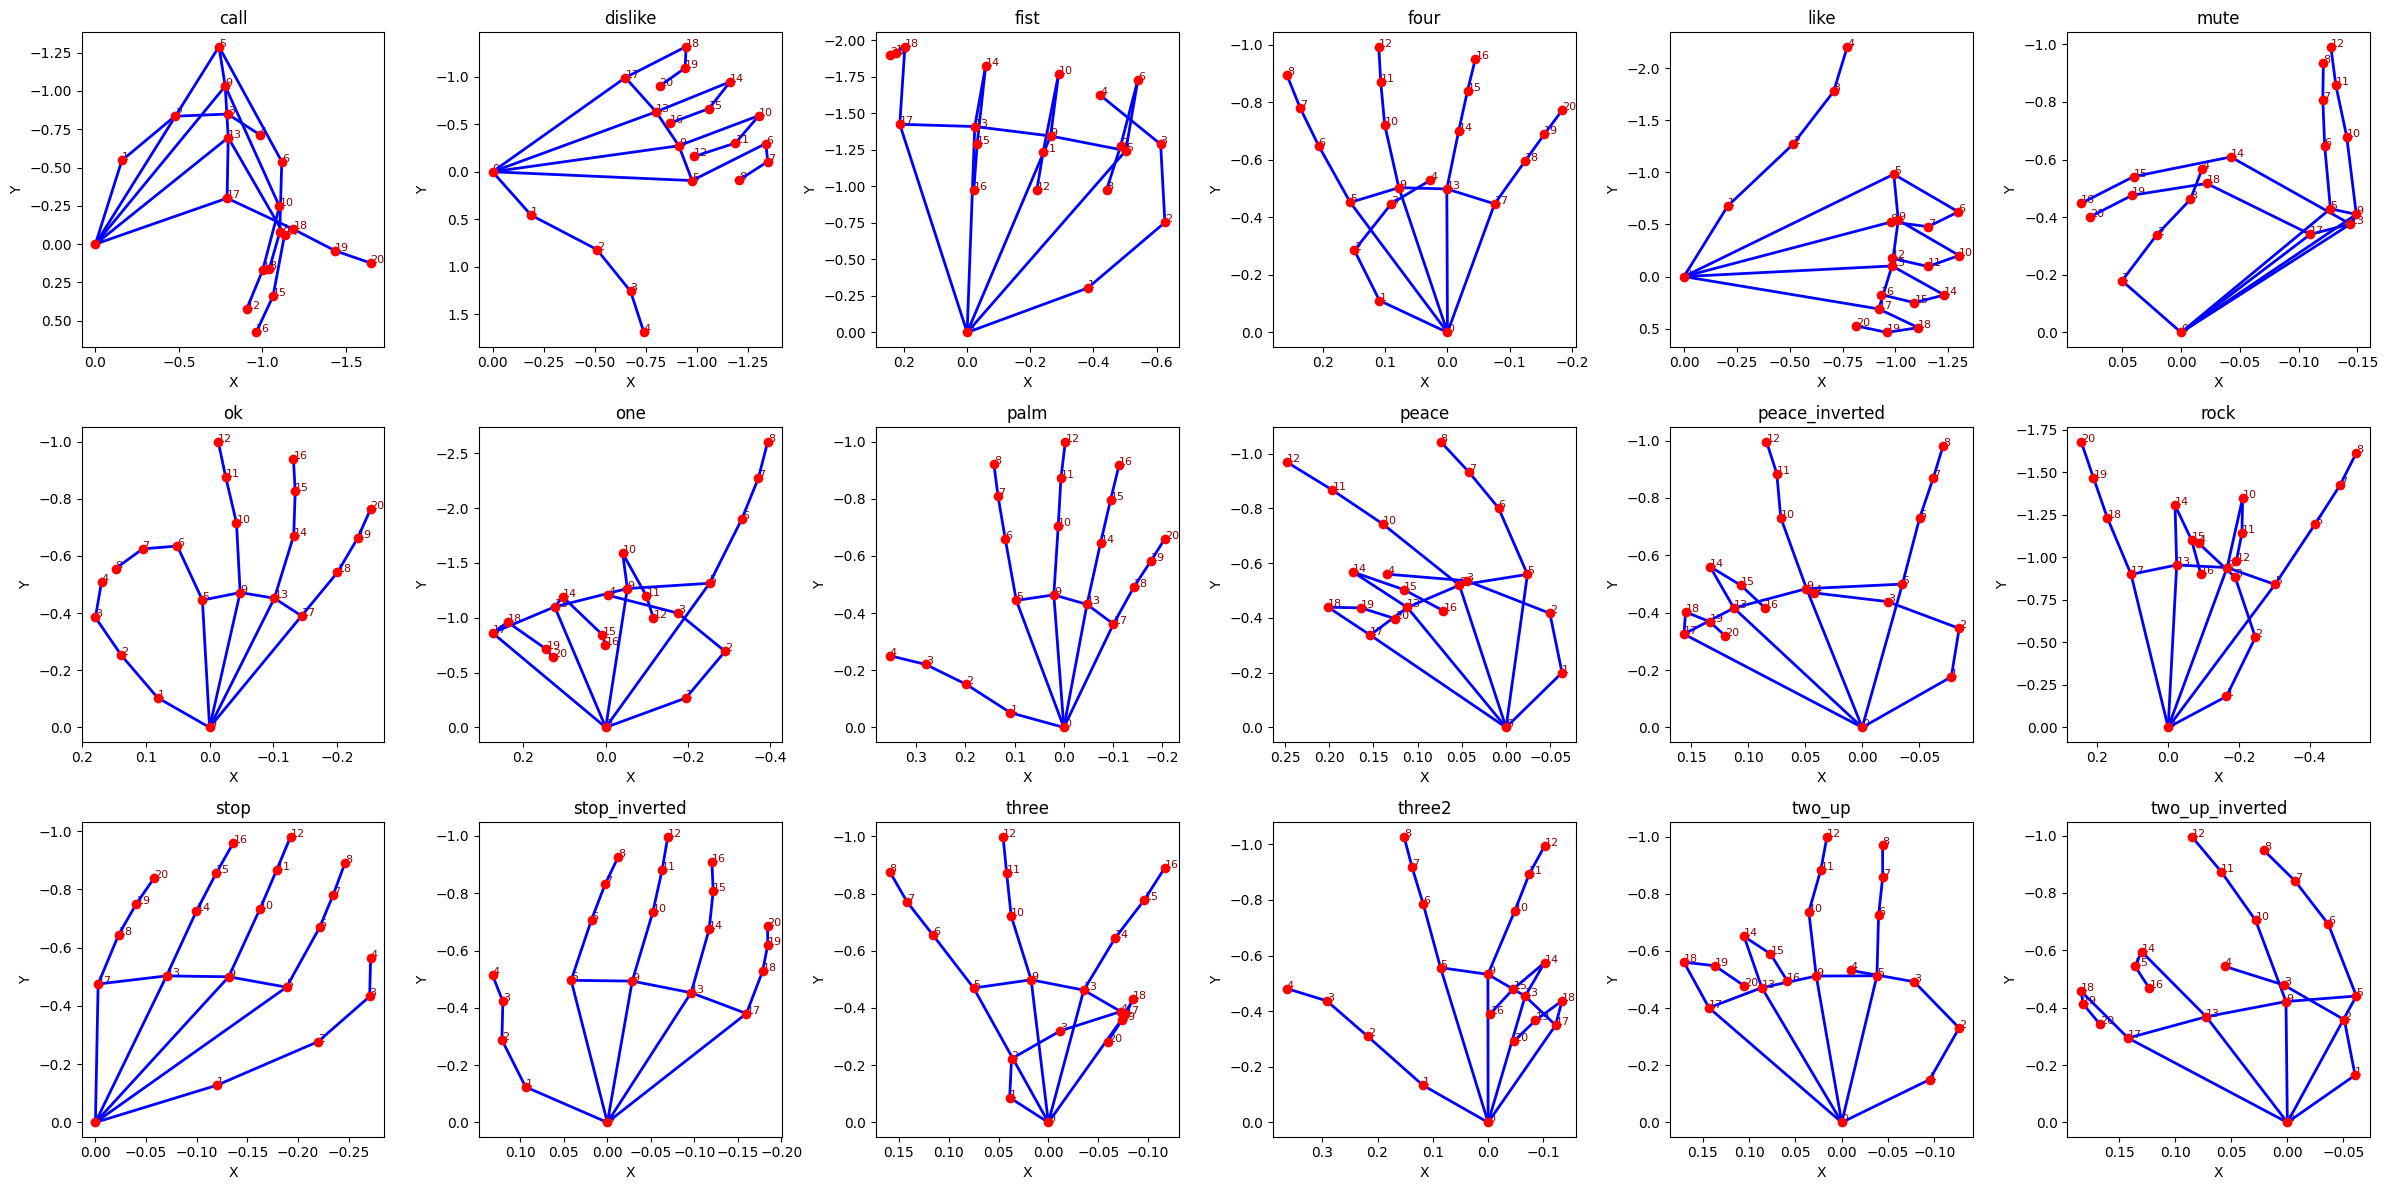

In [22]:
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axs = axs.flatten()

for ax, label in zip(axs, labels_unique):

    result = df_preprocessed[df.iloc[:, -1] == label].iloc[0]
    x_value = result.iloc[[i for i in range(0, 42, 2)]].values.astype(float)
    y_value = result.iloc[[i for i in range(1, 42, 2)]].values.astype(float)
    ax.scatter(x_value, y_value, color='red', zorder=5)


    for i, (x, y) in enumerate(zip(x_value, y_value)):
        ax.text(x, y, str(i), fontsize=8, color='darkred')
    for (i, j) in connections:
        if i < len(x_value) and j < len(x_value):
            ax.plot([x_value[i], x_value[j]], [y_value[i], y_value[j]],
                    'b-', linewidth=2, zorder=3)

    ax.set_title(label)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.invert_xaxis()

for i in range(len(labels_unique), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


We will also redraw the correlation matrix to know how the correlation was changed between the features and whether we can come up with useful relations

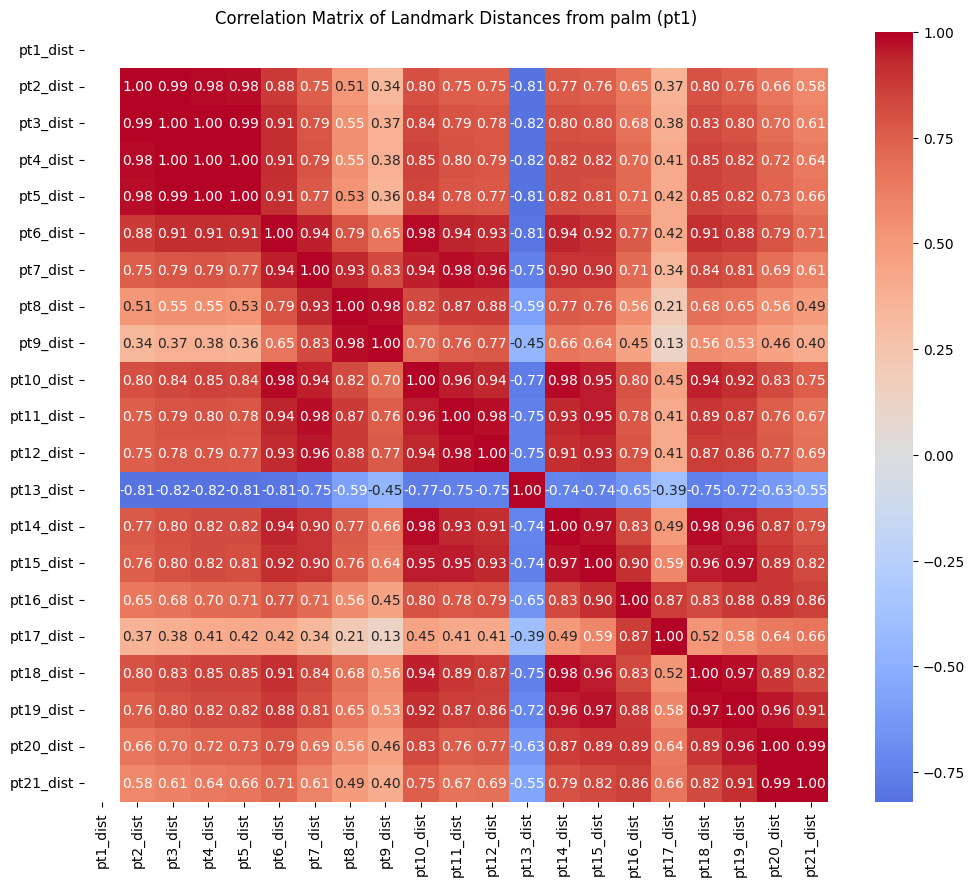

In [23]:
corr_matrix = compute_distance_corr(df_preprocessed, num_points=num_points, palm_idx=1)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from palm (pt1)")
plt.show()

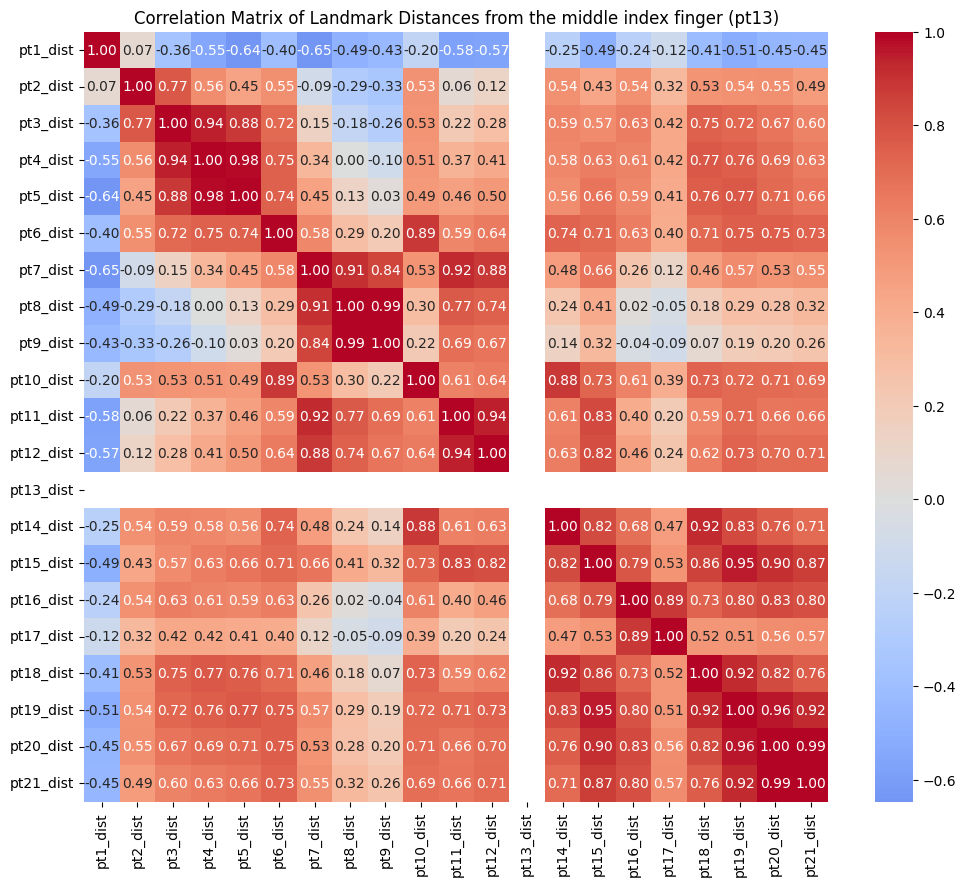

In [24]:
corr_matrix = compute_distance_corr(df_preprocessed, num_points=num_points, palm_idx=13)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from the middle index finger (pt13)")
plt.show()

As it is shown, some features have a correlation of around 0.99 and other are around 0.98. So, we will take them into consideration.

We will train 4 differants variants of the dataset, which are:
1- raw dataset, which will be trained without any preprocessing
2- preprocessed dataset, which will be trained after doing preprocessing only
3- preprocessed palm dataset, which will be trained after doing preprocessing and then dropping the heighly correlated columns according to the palm (x0,y0) 
4- preprocessed index dataset, which will be trained after doing preprocessing and then dropping the heighly correlated columns according to the middle index finger tip (x13,y13)


To ensure unification between those different datasets, we will use the same indicies that willbe generated by train_test_split to have those different datasets

In [25]:
X_train_master, X_test_master, y_train, y_test = train_test_split(
    df_preprocessed, labels, test_size=0.2, random_state=seed, stratify=labels
)

train_indices = X_train_master.index
test_indices = X_test_master.index
X_raw_train = df_raw.loc[train_indices]
X_raw_test = df_raw.loc[test_indices]
X_preprocessed_train = df_preprocessed.loc[train_indices]
X_preprocessed_test = df_preprocessed.loc[test_indices]

To make sure that there is no data leakage, we will first calculate the correlation matrix to the train set, and from it, we will drop the same columns for both the train and test sets and then we will draw the correlation matrix for the training set.

pt3_dist is correlated with pt2_dist (correlation = 0.9919). Dropping pt3_dist.
pt4_dist is correlated with pt2_dist (correlation = 0.9829). Dropping pt4_dist.
pt10_dist is correlated with pt6_dist (correlation = 0.9815). Dropping pt10_dist.
pt18_dist is correlated with pt14_dist (correlation = 0.9836). Dropping pt18_dist.
pt21_dist is correlated with pt20_dist (correlation = 0.9876). Dropping pt21_dist.
Features to drop (based on training set correlation): ['pt3_dist', 'pt4_dist', 'pt10_dist', 'pt18_dist', 'pt21_dist']


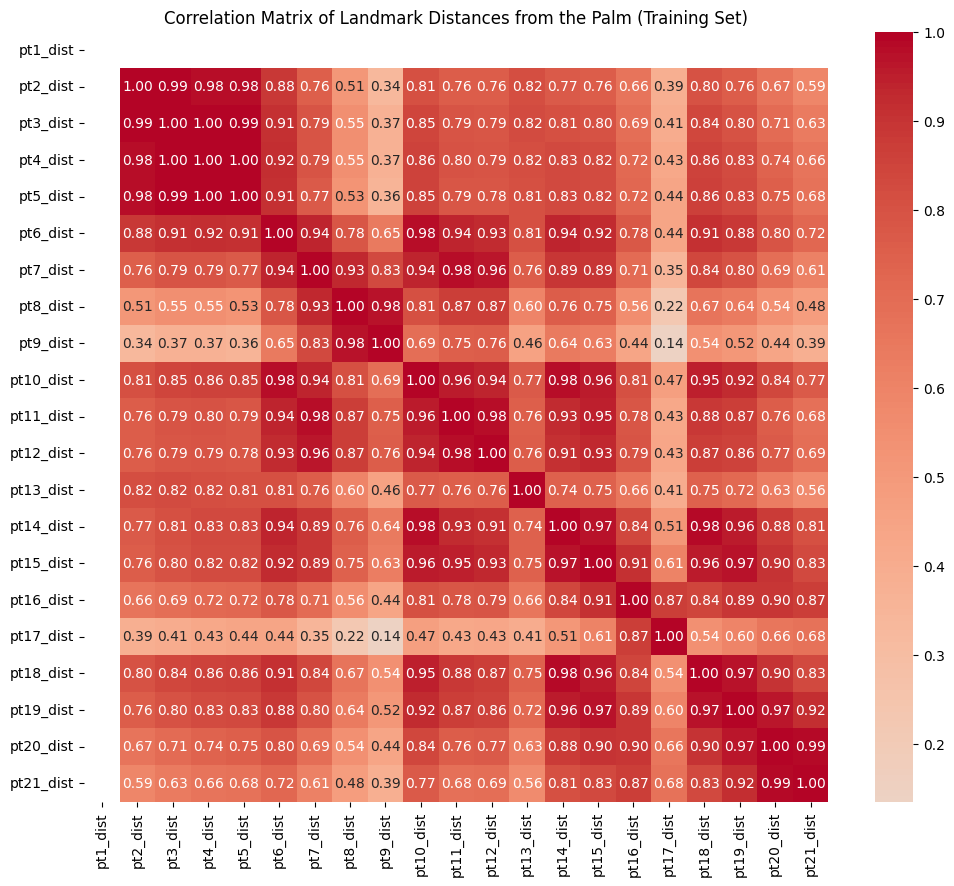

Shape of X_train before: (20540, 42) after dropping: (20540, 32)
Shape of X_test before: (5135, 42) after dropping: (5135, 32)


In [26]:
X_train_dist_palm = compute_distance_features(X_preprocessed_train , num_points=num_points, palm_idx=1)

to_drop_palm, corr_matrix_train = drop_highly_correlated_features(X_train_dist_palm, threshold=0.98)
print("Features to drop (based on training set correlation):", to_drop_palm)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from the Palm (Training Set)")
plt.show()

X_train_palm = drop_landmarks_from_data(X_preprocessed_train, to_drop_palm)
X_test_palm = drop_landmarks_from_data(X_preprocessed_test, to_drop_palm)
print("Shape of X_train before:", X_preprocessed_train.shape, "after dropping:", X_train_palm.shape)
print("Shape of X_test before:", X_preprocessed_test.shape, "after dropping:", X_test_palm.shape)

pt5_dist is correlated with pt4_dist (correlation = 0.9839). Dropping pt5_dist.
pt9_dist is correlated with pt8_dist (correlation = 0.9881). Dropping pt9_dist.
pt21_dist is correlated with pt20_dist (correlation = 0.9900). Dropping pt21_dist.
Features to drop (based on training set correlation): ['pt5_dist', 'pt9_dist', 'pt21_dist']


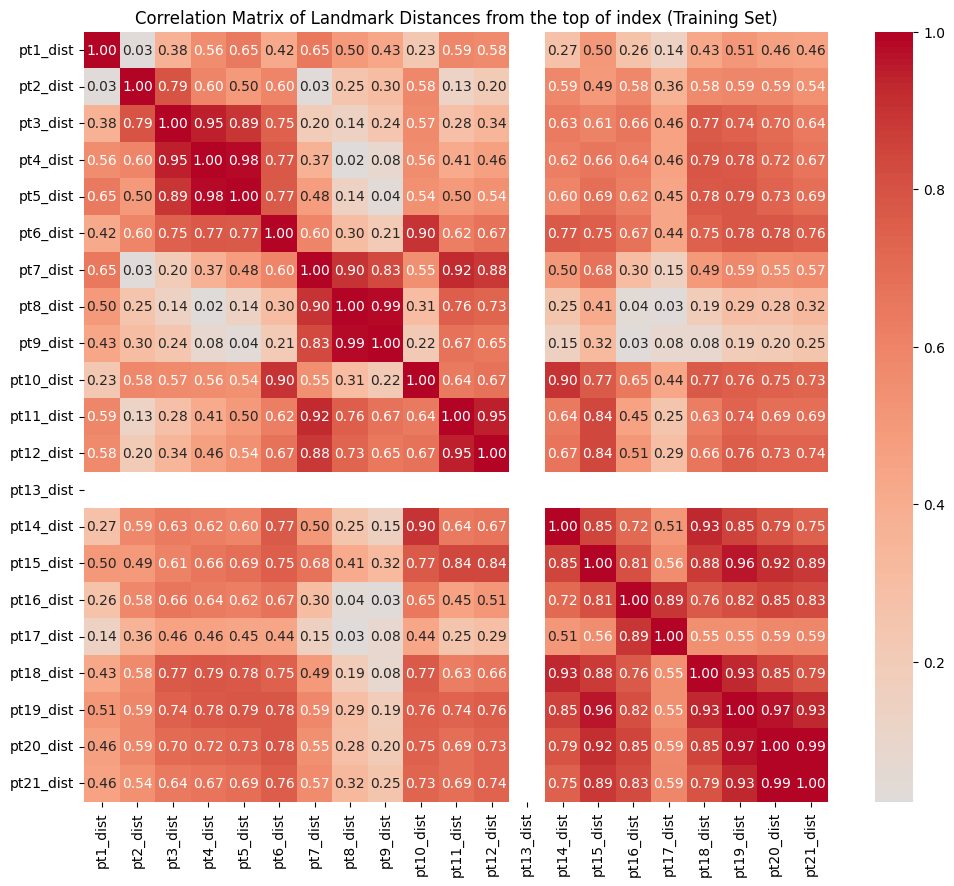

Shape of X_train before: (20540, 42) after dropping: (20540, 36)
Shape of X_test before: (5135, 42) after dropping: (5135, 36)


In [27]:
X_train_dist_index = compute_distance_features(X_preprocessed_train , num_points=num_points, palm_idx=13)

to_drop_index, corr_matrix_train = drop_highly_correlated_features(X_train_dist_index, threshold=0.98)
print("Features to drop (based on training set correlation):", to_drop_index)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Landmark Distances from the top of index (Training Set)")
plt.show()

X_train_index = drop_landmarks_from_data(X_preprocessed_train, to_drop_index)
X_test_index = drop_landmarks_from_data(X_preprocessed_test, to_drop_index)
print("Shape of X_train before:", X_preprocessed_train.shape, "after dropping:", X_train_index.shape)
print("Shape of X_test before:", X_preprocessed_test.shape, "after dropping:", X_test_index.shape)

As shown, some parameters have been dropped, so in the palm variant, there is 10 columns dropped, and the index variant  columns dropped which will reduce the curse of dimensionality

# Model Training and Evaluation

We will train 5 different classifiers which are:

1- Support Vector Machine (SVM)

2- Decision Tree

3- Random forest

4- Logistic Regression

5- XGBoost

Those classifiers are trained in a function called tune_model_with_performance, this function will take the train and test sets, along with a string called variant_name to help us identify which type of dataset was entered for the model, and the model_type that is default to SVM, to help identify which model to train, and finally a bool variable called use_GPU and it was in case for XGBoost, and a seed variable.

After specifying the model_type, we perform a random search to search for the best hyperparameter the model could have, after that we refine it a bit by extracting the best 3 hyperparameters and generating a boundary between them, and we feed this boundry to grid search to try and come up with the best possible combination of hyperparameters.

Finally, we will train a classifier with the best possible combination and generate our model,and visualizing the confusion matrix of our model.

After training the classifiers, we will evaluate their performance according to different criterias, mainly the accuracy, along with precision, recall, and F1-score. Also we will look at there training time, inference time, memory usage and CPU usage. Which will help us to evaluate the different models.

Also, we will use MLflow to make the expirements reproducible, and to be able to log the different paramters in case we needed to reproduce the expirement.

Those are the helper functions that will be used with our main function, they have a purpose of calculating the memory and the CPU usages, along with the inference time.

The refine_bounds function has a purpose to helping in reducing the grid of searching for the grid search

Also we will save the generated model, along with the output of the function in a directory called 'outputs/' to make it easier to retrieve a certain model and/or its performance metrics in case we need to do further analysis in the future like we retrieved the model for the MediaPipe phase, we save the model in .pkl format and the performance metrics, best hyperparameters and accuracy in .pkl, .json and .txt format, and this in case different people from different domains are going to work on it.

In [28]:
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

def get_inference_time(model, X_test, num_runs=10):
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        model.predict(X_test)
        end_time = time.time()
        times.append((end_time - start_time) * 1000)
    return np.mean(times)

def get_cpu_usage():
    return psutil.cpu_percent(interval=1)

def refine_bounds(best_val, top_vals, lower_factor=0.9, upper_factor=1.1):
    """
    Given a best value (best_val) and a list of top competitor values (top_vals) for a hyperparameter,
    compute refined lower and upper bounds.
    
    We first compute candidate bounds as:
         candidate_lower = best_val * lower_factor
         candidate_upper = best_val * upper_factor
    Then we look at competitor values:
      - For the lower bound, if any competitor is less than best_val and greater than candidate_lower,
        we set new_lower to the maximum of those competitor values.
      - For the upper bound, if any competitor is greater than best_val and less than candidate_upper,
        we set new_upper to the minimum of those competitor values.
      
    Finally, we ensure that best_val lies within the refined range.
    If not, we revert that bound to the candidate value.
    """
    candidate_lower = best_val * lower_factor
    candidate_upper = best_val * upper_factor
    
    print(f'top vals: {top_vals}')
    competitors_below = [val for val in top_vals if val < best_val]
    print(f'competitors below: {competitors_below}')
    if competitors_below:
        new_lower = max(candidate_lower, max(competitors_below))
    else:
        new_lower = candidate_lower

    competitors_above = [val for val in top_vals if val > best_val]
    print(f'competitors above: {competitors_above}')
    if competitors_above:
        new_upper = min(candidate_upper, min(competitors_above))
    else:
        new_upper = candidate_upper

    if not (new_lower <= best_val <= new_upper):
        new_lower, new_upper = candidate_lower, candidate_upper
        
    return new_lower, new_upper

    
def numpy_default(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

        
def save_tuning_outputs(best_model, best_params, acc, performance_metrics, file_path):
    """
    Saves the outputs from the tuning process to the given file path.
    
    Outputs saved:
      - best_model: Pickle file.
      - best_params: Text file, JSON file, and Pickle file.
      - acc (accuracy): Text file, JSON file, and Pickle file.
      - performance_metrics: Text file, JSON file, and Pickle file.
    
    Parameters:
      best_model: The best estimator returned by your tuning function.
      best_params: The dictionary of best hyperparameters.
      acc: The test accuracy (float).
      performance_metrics: A dictionary of additional metrics (e.g., inference time, memory used, etc.).
      file_path: The directory path where to save the files.
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    model_filename = os.path.join(file_path, "best_model.pkl")
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)
    
    best_params_txt = os.path.join(file_path, "best_params.txt")
    with open(best_params_txt, "w") as f:
        f.write(str(best_params))
    
    best_params_json = os.path.join(file_path, "best_params.json")
    with open(best_params_json, "w") as f:
        json.dump(best_params, f, indent=4, default=numpy_default)
    
    best_params_pickle = os.path.join(file_path, "best_params.pkl")
    with open(best_params_pickle, "wb") as f:
        pickle.dump(best_params, f)
    
    acc_txt = os.path.join(file_path, "accuracy.txt")
    with open(acc_txt, "w") as f:
        f.write(str(acc))
    
    acc_json = os.path.join(file_path, "accuracy.json")
    with open(acc_json, "w") as f:
        json.dump({"accuracy": acc}, f, indent=4, default=numpy_default)
    
    acc_pickle = os.path.join(file_path, "accuracy.pkl")
    with open(acc_pickle, "wb") as f:
        pickle.dump(acc, f)
     
    perf_txt = os.path.join(file_path, "performance_metrics.txt")
    with open(perf_txt, "w") as f:
        f.write(str(performance_metrics))
    
    perf_json = os.path.join(file_path, "performance_metrics.json")
    with open(perf_json, "w") as f:
        json.dump(performance_metrics, f, indent=4, default=numpy_default)
    
    perf_pickle = os.path.join(file_path, "performance_metrics.pkl")
    with open(perf_pickle, "wb") as f:
        pickle.dump(performance_metrics, f)

In [29]:
def tune_model_with_performance(X_train, X_test, y_train, y_test, variant_name, model_type="SVM", use_GPU=True, seed=seed):
    """
    Multi-stage hyperparameter tuning and performance evaluation for different model types.
    Supported model_type: "SVM", "DecisionTree", RandomForest, "LogisticRegression", "XGBoost".
    
    The function performs:
      - A random search over a wide parameter space.
      - A grid search around the best parameters.
      - A second random search in a refined region.
      - A final grid search over a narrow grid.
    
    It then evaluates the best model on the test set, logging accuracy, precision, recall, f1_score,
    inference time, memory usage, and CPU usage via MLflow.
    
    Prints all performance metrics to the screen.
    
    Returns the best model, best parameters, test accuracy, and a dictionary of performance metrics.
    """
    # Select model and parameter search spaces based on model_type
    if model_type == "SVM":
        base_model = SVC(random_state=seed)
        param_dist_1 = {
            'C': loguniform(1e-3, 1e3),
            'gamma': loguniform(1e-4, 1e1),
            'kernel': ['rbf', 'linear']
        }
        int_params = []
    elif model_type == "DecisionTree":
        base_model = DecisionTreeClassifier(random_state=seed)
        param_dist_1 = {
            'max_depth': [None] + list(np.arange(3, 20)),
            'min_samples_split': np.arange(2, 20),
            'min_samples_leaf': np.arange(1, 20),
            'max_features': ['auto', 'sqrt', 'log2', None],
            'criterion': ['gini', 'entropy']
        }
        int_params = ['max_depth', 'min_samples_split']
        
    elif model_type == "RandomForest":
        base_model = RandomForestClassifier(random_state=seed)
        param_dist_1 = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None] + list(np.arange(3, 20)),
            'min_samples_split': np.arange(2, 20),
            'min_samples_leaf': np.arange(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
        }
        int_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

    elif model_type == "LogisticRegression":
        base_model = LogisticRegression(random_state=seed, max_iter=5000)
        param_dist_1 = {
            'C': loguniform(1e-3, 1e3),
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga'],
            'multi_class': ['ovr', 'multinomial'],              
            'class_weight': [None, 'balanced'],                 
            'tol': loguniform(1e-5, 1e-2),                      
            'fit_intercept': [True, False]
        }
        int_params = []
    elif model_type == "XGBoost":
        if use_GPU:
            base_model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss', tree_method='hist', device='cuda')
        else:
            base_model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss', tree_method='hist')
        param_dist_1 = {
            'n_estimators': [50, 100, 200],
            'max_depth': np.arange(3, 10),
            'learning_rate': loguniform(1e-3, 1e-1),
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]

        }
        int_params = ['n_estimators', 'max_depth']

    else:
        raise ValueError("Unsupported model type. Choose from 'SVM', 'DecisionTree', 'RandomForest', 'LogisticRegression', or 'XGBoost'.")
    
    # Phase 1: Random Search
    random_search_1 = RandomizedSearchCV(base_model, param_distributions=param_dist_1,
                                         n_iter=20, cv=3, random_state=seed, n_jobs=-1)
    random_search_1.fit(X_train, y_train)
    best_params_1 = random_search_1.best_params_
    
    print('Random finished')

    # Phase 2: Grid Search
    sorted_results = sorted(random_search_1.cv_results_['params'], key=lambda p: p.get('mean_test_score', 0), reverse=True)
    top_params = [p for p in sorted_results[:3]]    
    bounded_params = ['subsample', 'colsample_bytree']
    grid_params = {}
    for key, value in best_params_1.items():
        if type(value) is bool:
            grid_params[key] = [value]
        elif isinstance(value, (int, float)):
            top_vals = [p[key] for p in top_params if key in p and p[key] != value]
            new_lower, new_upper = refine_bounds(value, top_vals)
            grid_range = np.linspace(new_lower, new_upper, num=3).tolist()  # 3 values between new bounds
            if key in int_params:
                grid_range = [int(round(x)) for x in grid_range]
            if key in bounded_params:
                grid_range = [min(x, 1.0) for x in grid_range]
            grid_params[key] = grid_range
        else:
            grid_params[key] = [value]
            
    grid_search_2 = GridSearchCV(base_model, param_grid=grid_params, cv=5, n_jobs=-1)
    grid_search_2.fit(X_train, y_train)
    best_params_2 = grid_search_2.best_params_
    best_params_final = grid_search_2.best_params_
    best_model = grid_search_2.best_estimator_
    print('Grid finished')

    # Phase 3: Build best model
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    report = classification_report(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    cm_filename = f"{variant_name}_{model_type}_confusion_matrix.png"
    plt.savefig(cm_filename)
    plt.show()  
    plt.close()
    
    tracemalloc.start()
    memory_before = get_memory_usage()
    inf_time = get_inference_time(best_model, X_test)
    memory_after = get_memory_usage()
    tracemalloc.stop()
    cpu_usage = get_cpu_usage()
    memory_used = memory_after - memory_before
    
    performance_metrics = {
        "inference_time_ms": inf_time,
        "memory_used_mb": memory_used,
        "cpu_usage_percent": cpu_usage,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": acc
    }
    

    report_filename = f"{variant_name}_{model_type}_classification_report.txt"
    with open(report_filename, "w") as f:
        f.write(report)
    
    with mlflow.start_run(run_name=f"{variant_name}_{model_type}_tuning"):
        mlflow.log_param("variant", variant_name)
        mlflow.log_param("model_type", model_type)
        mlflow.log_params(best_params_final)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("inference_time_ms", inf_time)
        mlflow.log_metric("memory_used_mb", memory_used)
        mlflow.log_metric("cpu_usage_percent", cpu_usage)
        mlflow.log_artifact(report_filename)
        mlflow.log_artifact(cm_filename)
        mlflow.sklearn.log_model(best_model, "model", input_example=X_train.iloc[[0]])
        
        print(f"{variant_name} {model_type} best parameters: {best_params_final}")
        print(f"{variant_name} {model_type} test accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"Inference time (ms): {inf_time:.2f}")
        print(f"Memory used (MB): {memory_used:.2f}")
        print(f"CPU usage (%): {cpu_usage:.2f}")
        print(report)
    
    return best_model, best_params_final, acc, performance_metrics

### SVM
We genetrate the first model of SVM classifiers

In [20]:
model_name = 'SVM'

Tuning Raw Variant with SVM:
Random finished
top vals: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors below: [0.17670169402947947, 0.008629132190071855]
competitors above: [47.659118086808384]
top vals: [5.669849511478852, 0.09643857615941433, 0.00019517224641449492]
competitors below: [0.00019517224641449492]
competitors above: [5.669849511478852, 0.09643857615941433]
Grid finished


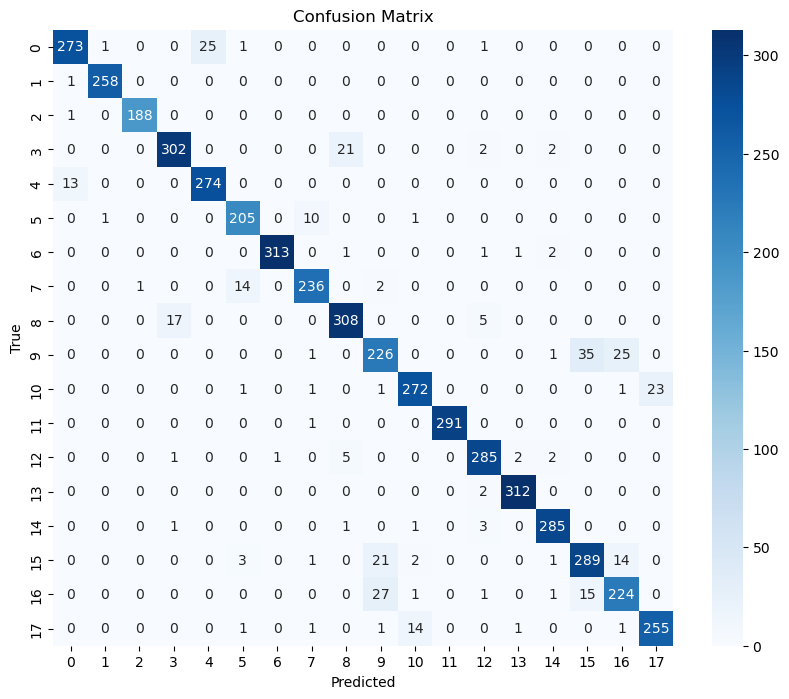

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Raw_Variant SVM best parameters: {'C': 4.220460867183921, 'gamma': 0.0004484477121368804, 'kernel': 'linear'}
Raw_Variant SVM test accuracy: 0.9340
Precision: 0.9348, Recall: 0.9353, F1-score: 0.9349
Inference time (ms): 801.60
Memory used (MB): 0.09
CPU usage (%): 0.00
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       301
           1       0.99      1.00      0.99       259
           2       0.99      0.99      0.99       189
           3       0.94      0.92      0.93       327
           4       0.92      0.95      0.94       287
           5       0.91      0.94      0.93       217
           6       1.00      0.98      0.99       318
           7       0.94      0.93      0.94       253
           8       0.92      0.93      0.92       330
           9       0.81      0.78      0.80       288
          10       0.93      0.91      0.92       299
          11       1.00      1.00      1.00       292
          12       0.95   

In [100]:
%%time
print(f'Tuning Raw Variant with {model_name}:')
model_raw, params_raw, acc_raw, perf_raw = tune_model_with_performance(X_raw_train, X_raw_test, y_train, y_test, variant_name="Raw_Variant", model_type=model_name)

In [101]:
path = 'outputs/'+model_name+'/'
model_type = 'raw/'
save_tuning_outputs(model_raw, params_raw, acc_raw, perf_raw,path+model_type)

Tuning Preprocessed Variant with SVM:
Random finished
top vals: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors below: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors above: []
top vals: [5.669849511478852, 0.09643857615941433, 0.00019517224641449492]
competitors below: [0.00019517224641449492]
competitors above: [5.669849511478852, 0.09643857615941433]
Grid finished


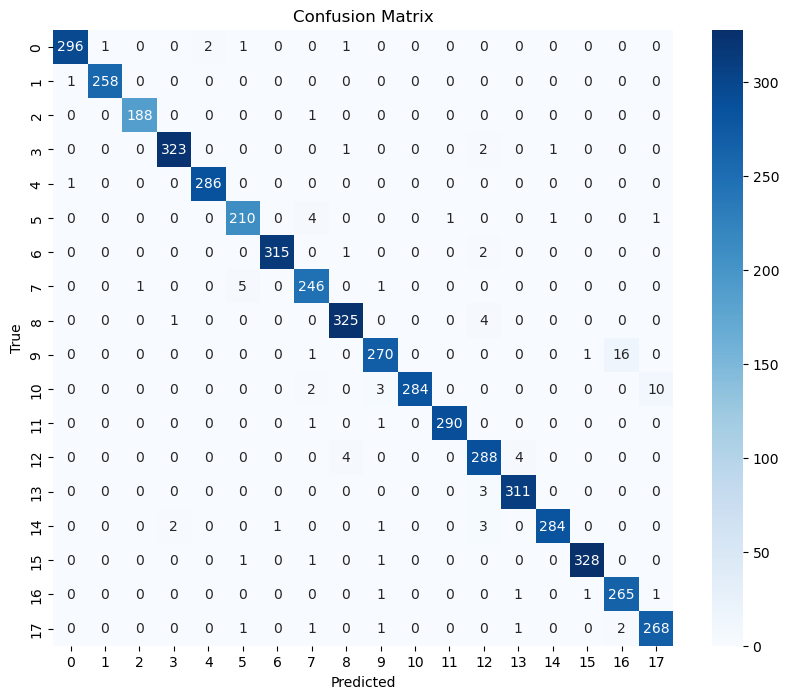

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Variant SVM best parameters: {'C': 872.5252422489411, 'gamma': 0.02372505082119036, 'kernel': 'rbf'}
Preprocessed_Variant SVM test accuracy: 0.9805
Precision: 0.9802, Recall: 0.9804, F1-score: 0.9802
Inference time (ms): 2070.80
Memory used (MB): 0.01
CPU usage (%): 1.30
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.99      0.99      0.99       327
           4       0.99      1.00      0.99       287
           5       0.96      0.97      0.97       217
           6       1.00      0.99      0.99       318
           7       0.96      0.97      0.96       253
           8       0.98      0.98      0.98       330
           9       0.97      0.94      0.95       288
          10       1.00      0.95      0.97       299
          11       1.00      0.99      0.99       292
          12

In [23]:
%%time
print(f'Tuning Preprocessed Variant with {model_name}:')
model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed = tune_model_with_performance(X_preprocessed_train, X_preprocessed_test, y_train, y_test, variant_name="Preprocessed_Variant", model_type=model_name)

In [24]:
model_type = 'preprocessed/'
save_tuning_outputs(model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed,path+model_type)

Tuning Palm Variant with SVM:
Random finished
top vals: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors below: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors above: []
top vals: [5.669849511478852, 0.09643857615941433, 0.00019517224641449492]
competitors below: [0.00019517224641449492]
competitors above: [5.669849511478852, 0.09643857615941433]
Grid finished


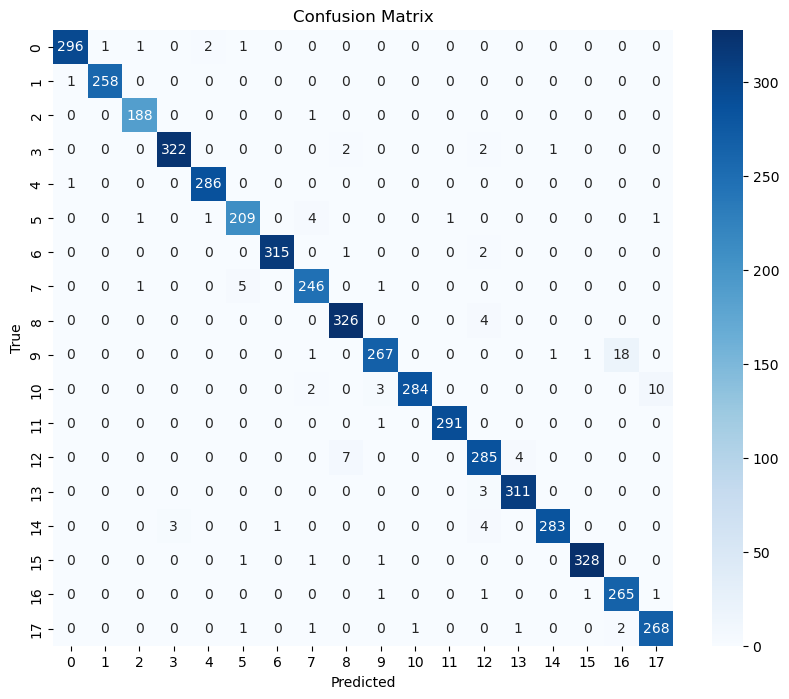

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Palm_Variant SVM best parameters: {'C': 872.5252422489411, 'gamma': 0.02372505082119036, 'kernel': 'rbf'}
Preprocessed_Palm_Variant SVM test accuracy: 0.9792
Precision: 0.9788, Recall: 0.9790, F1-score: 0.9788
Inference time (ms): 2274.70
Memory used (MB): 0.00
CPU usage (%): 3.50
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       301
           1       1.00      1.00      1.00       259
           2       0.98      0.99      0.99       189
           3       0.99      0.98      0.99       327
           4       0.99      1.00      0.99       287
           5       0.96      0.96      0.96       217
           6       1.00      0.99      0.99       318
           7       0.96      0.97      0.97       253
           8       0.97      0.99      0.98       330
           9       0.97      0.93      0.95       288
          10       1.00      0.95      0.97       299
          11       1.00      1.00      1.00       292
  

In [25]:
%%time
print(f'Tuning Palm Variant with {model_name}:')
model_palm, params_palm, acc_palm, perf_palm = tune_model_with_performance(X_train_palm, X_test_palm, y_train, y_test, variant_name="Preprocessed_Palm_Variant", model_type=model_name)

In [26]:
model_type = 'palm/'
save_tuning_outputs(model_palm, params_palm, acc_palm, perf_palm,path+model_type)

Tuning Index Variant with SVM:
Random finished
top vals: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors below: [0.17670169402947947, 47.659118086808384, 0.008629132190071855]
competitors above: []
top vals: [5.669849511478852, 0.09643857615941433, 0.00019517224641449492]
competitors below: [0.00019517224641449492]
competitors above: [5.669849511478852, 0.09643857615941433]
Grid finished


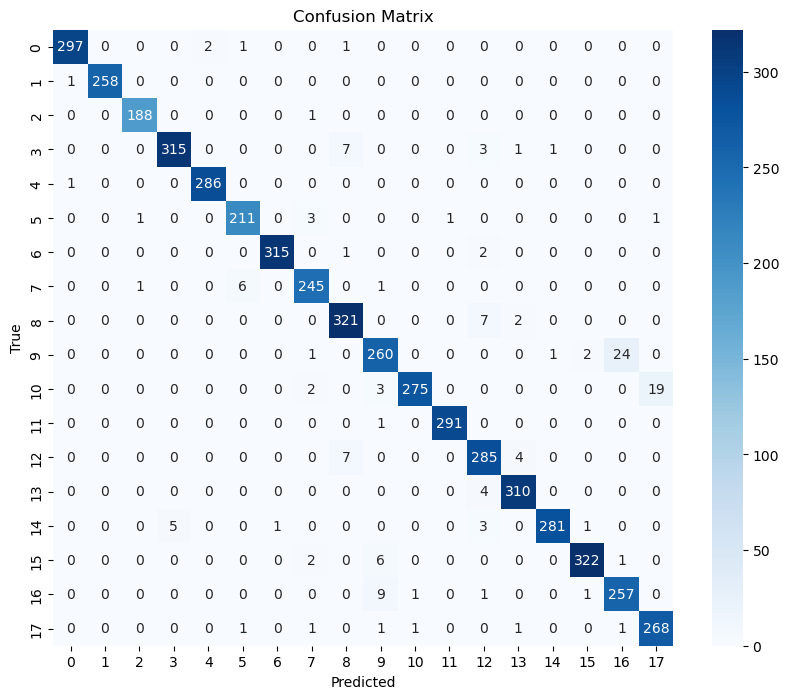

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Index_Variant SVM best parameters: {'C': 872.5252422489411, 'gamma': 0.02372505082119036, 'kernel': 'rbf'}
Preprocessed_Index_Variant SVM test accuracy: 0.9708
Precision: 0.9709, Recall: 0.9713, F1-score: 0.9709
Inference time (ms): 2743.90
Memory used (MB): 0.13
CPU usage (%): 10.80
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.98      0.96      0.97       327
           4       0.99      1.00      0.99       287
           5       0.96      0.97      0.97       217
           6       1.00      0.99      0.99       318
           7       0.96      0.97      0.96       253
           8       0.95      0.97      0.96       330
           9       0.93      0.90      0.91       288
          10       0.99      0.92      0.95       299
          11       1.00      1.00      1.00       292

In [27]:
%%time
print(f'Tuning Index Variant with {model_name}:')
model_index, params_index, acc_index, perf_index = tune_model_with_performance(X_train_index, X_test_index, y_train, y_test, variant_name="Preprocessed_Index_Variant", model_type=model_name)

In [28]:
model_type = 'index/'
save_tuning_outputs(model_index, params_index, acc_index, perf_index,path+model_type)

### DecisionTree
We genetrate the second model of Decision Tree classifiers, we built here only a single tree to make the decision

In [50]:
model_name = 'DecisionTree'

Tuning Raw Variant with DecisionTree:


C:\Users\marha\anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Random finished


C:\Users\marha\anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Grid finished


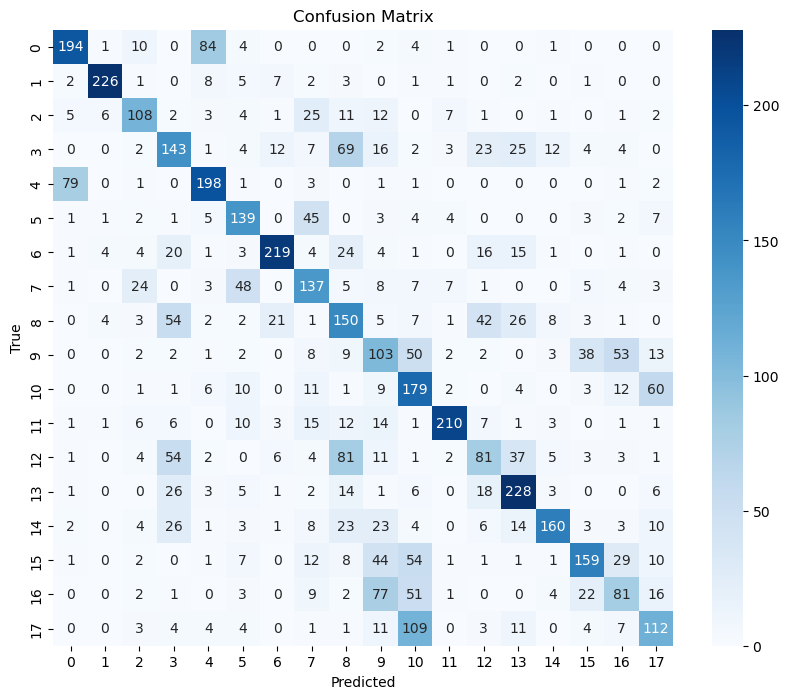

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Raw_Variant DecisionTree best parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 4}
Raw_Variant DecisionTree test accuracy: 0.5505
Precision: 0.5713, Recall: 0.5531, F1-score: 0.5559
Inference time (ms): 3.30
Memory used (MB): 0.36
CPU usage (%): 1.00
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       301
           1       0.93      0.87      0.90       259
           2       0.60      0.57      0.59       189
           3       0.42      0.44      0.43       327
           4       0.61      0.69      0.65       287
           5       0.55      0.64      0.59       217
           6       0.81      0.69      0.74       318
           7       0.47      0.54      0.50       253
           8       0.36      0.45      0.40       330
           9       0.30      0.36      0.33       288
          10       0.37      0.60      0.46       299
          11       0.87      0.

In [53]:
%%time
print(f'Tuning Raw Variant with {model_name}:')
model_raw, params_raw, acc_raw, perf_raw = tune_model_with_performance(X_raw_train, X_raw_test, y_train, y_test, variant_name="Raw_Variant", model_type=model_name)

In [54]:
path = 'outputs/'+model_name+'/'
model_type = 'raw/'
save_tuning_outputs(model_raw, params_raw, acc_raw, perf_raw,path+model_type)

Tuning Preprocessed Variant with DecisionTree:
Random finished
Grid finished


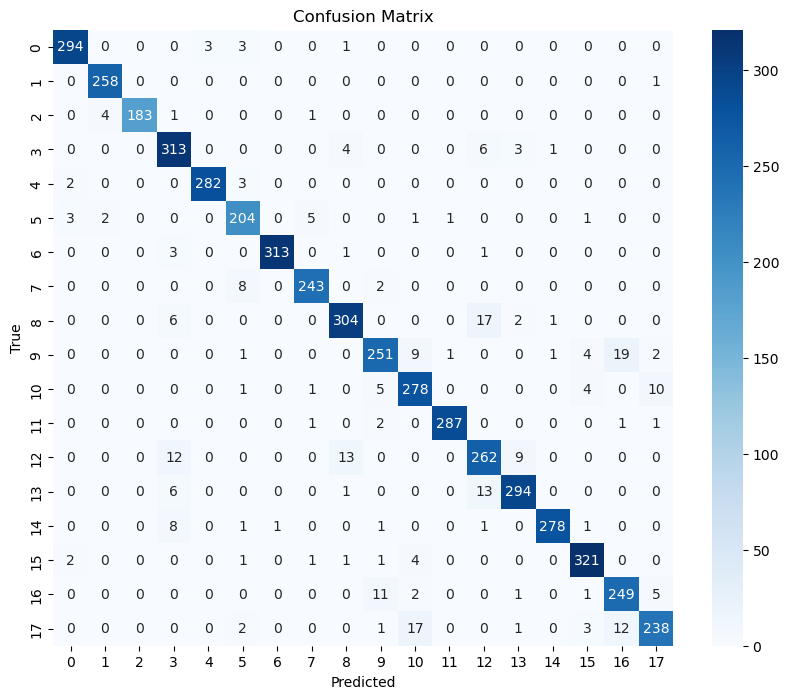

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Variant DecisionTree best parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Preprocessed_Variant DecisionTree test accuracy: 0.9449
Precision: 0.9462, Recall: 0.9451, F1-score: 0.9454
Inference time (ms): 5.40
Memory used (MB): 1.38
CPU usage (%): 16.30
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       301
           1       0.98      1.00      0.99       259
           2       1.00      0.97      0.98       189
           3       0.90      0.96      0.93       327
           4       0.99      0.98      0.99       287
           5       0.91      0.94      0.93       217
           6       1.00      0.98      0.99       318
           7       0.96      0.96      0.96       253
           8       0.94      0.92      0.93       330
           9       0.92      0.87      0.89       288
          10       0.89      0.93      0.91       299
          11  

In [55]:
%%time
print(f'Tuning Preprocessed Variant with {model_name}:')
model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed = tune_model_with_performance(X_preprocessed_train, X_preprocessed_test, y_train, y_test, variant_name="Preprocessed_Variant", model_type=model_name)

In [56]:
model_type = 'preprocessed/'
save_tuning_outputs(model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed,path+model_type)

Tuning Palm Variant with DecisionTree:
Random finished
Grid finished


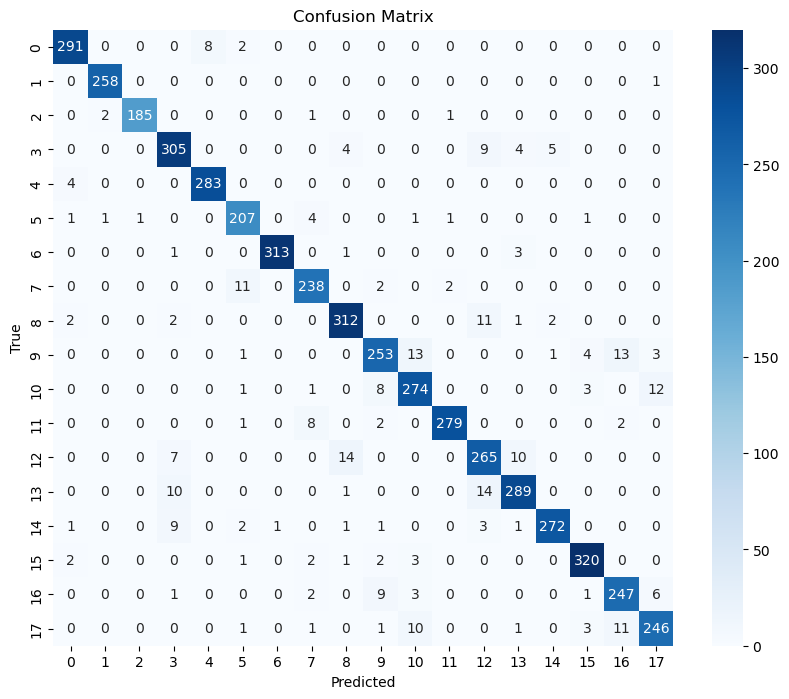

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Palm_Variant DecisionTree best parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Preprocessed_Palm_Variant DecisionTree test accuracy: 0.9420
Precision: 0.9428, Recall: 0.9427, F1-score: 0.9426
Inference time (ms): 3.10
Memory used (MB): 0.08
CPU usage (%): 13.70
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       301
           1       0.99      1.00      0.99       259
           2       0.99      0.98      0.99       189
           3       0.91      0.93      0.92       327
           4       0.97      0.99      0.98       287
           5       0.91      0.95      0.93       217
           6       1.00      0.98      0.99       318
           7       0.93      0.94      0.93       253
           8       0.93      0.95      0.94       330
           9       0.91      0.88      0.89       288
          10       0.90      0.92      0.91       299
    

In [57]:
%%time
print(f'Tuning Palm Variant with {model_name}:')
model_palm, params_palm, acc_palm, perf_palm = tune_model_with_performance(X_train_palm, X_test_palm, y_train, y_test, variant_name="Preprocessed_Palm_Variant", model_type=model_name)


In [58]:
model_type = 'palm/'
save_tuning_outputs(model_palm, params_palm, acc_palm, perf_palm,path+model_type)

Tuning Index Variant with DecisionTree:
Random finished
Grid finished


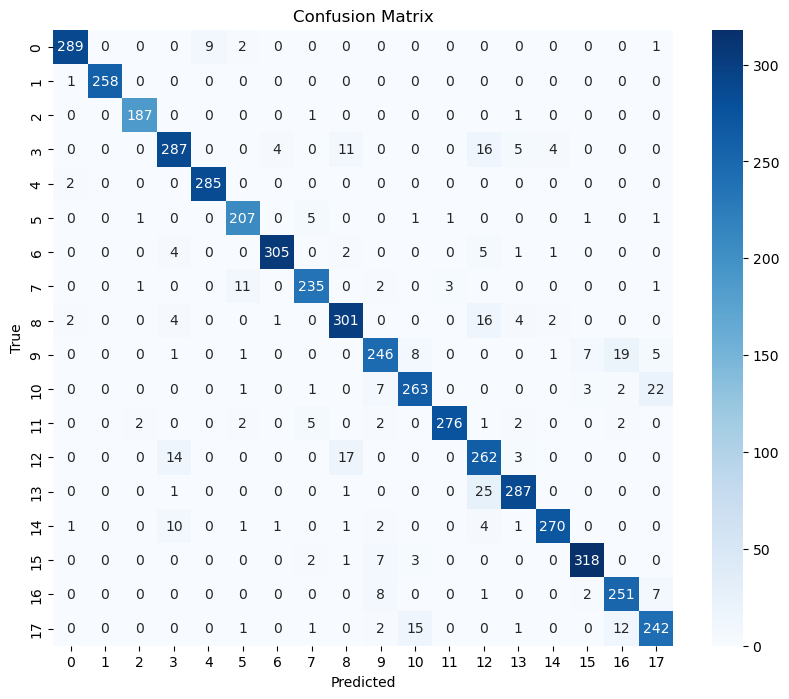

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Index_Variant DecisionTree best parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Preprocessed_Index_Variant DecisionTree test accuracy: 0.9287
Precision: 0.9309, Recall: 0.9307, F1-score: 0.9305
Inference time (ms): 3.10
Memory used (MB): 0.00
CPU usage (%): 22.10
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       301
           1       1.00      1.00      1.00       259
           2       0.98      0.99      0.98       189
           3       0.89      0.88      0.89       327
           4       0.97      0.99      0.98       287
           5       0.92      0.95      0.93       217
           6       0.98      0.96      0.97       318
           7       0.94      0.93      0.93       253
           8       0.90      0.91      0.91       330
           9       0.89      0.85      0.87       288
          10       0.91      0.88      0.89       299
  

In [59]:
%%time
print(f'Tuning Index Variant with {model_name}:')
model_index, params_index, acc_index, perf_index = tune_model_with_performance(X_train_index, X_test_index, y_train, y_test, variant_name="Preprocessed_Index_Variant", model_type=model_name)

In [60]:
model_type = 'index/'
save_tuning_outputs(model_index, params_index, acc_index, perf_index,path+model_type)

### RandomForest
We genetrate the third model of Random Forest classifiers

In [68]:
model_name = 'RandomForest'

Tuning Raw Variant with RandomForest:
Random finished
top vals: [50, 100]
competitors below: [50, 100]
competitors above: []
Grid finished


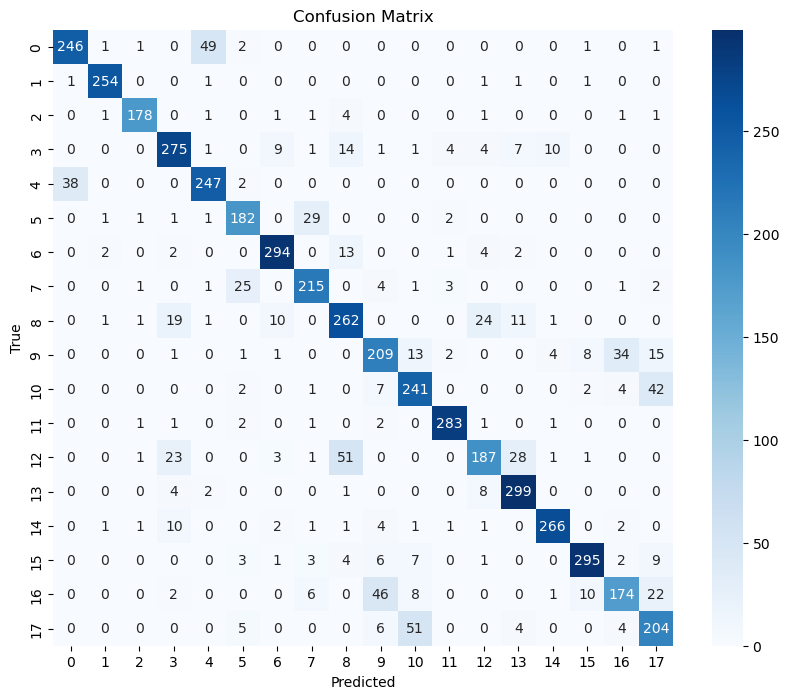

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Raw_Variant RandomForest best parameters: {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 220}
Raw_Variant RandomForest test accuracy: 0.8395
Precision: 0.8422, Recall: 0.8406, F1-score: 0.8400
Inference time (ms): 322.60
Memory used (MB): 210.33
CPU usage (%): 5.60
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       301
           1       0.97      0.98      0.98       259
           2       0.96      0.94      0.95       189
           3       0.81      0.84      0.83       327
           4       0.81      0.86      0.84       287
           5       0.81      0.84      0.83       217
           6       0.92      0.92      0.92       318
           7       0.83      0.85      0.84       253
           8       0.75      0.79      0.77       330
           9       0.73      0.73      0.73       288
          10       0.75      0.81      0.77       299
       

In [69]:
%%time
print(f'Tuning Raw Variant with {model_name}:')
model_raw, params_raw, acc_raw, perf_raw = tune_model_with_performance(X_raw_train, X_raw_test, y_train, y_test, variant_name="Raw_Variant", model_type=model_name)

In [70]:
path = 'outputs/'+model_name+'/'
model_type = 'raw/'
save_tuning_outputs(model_raw, params_raw, acc_raw, perf_raw,path+model_type)

Tuning Preprocessed Variant with RandomForest:
Random finished
top vals: [50, 100]
competitors below: [50, 100]
competitors above: []
Grid finished


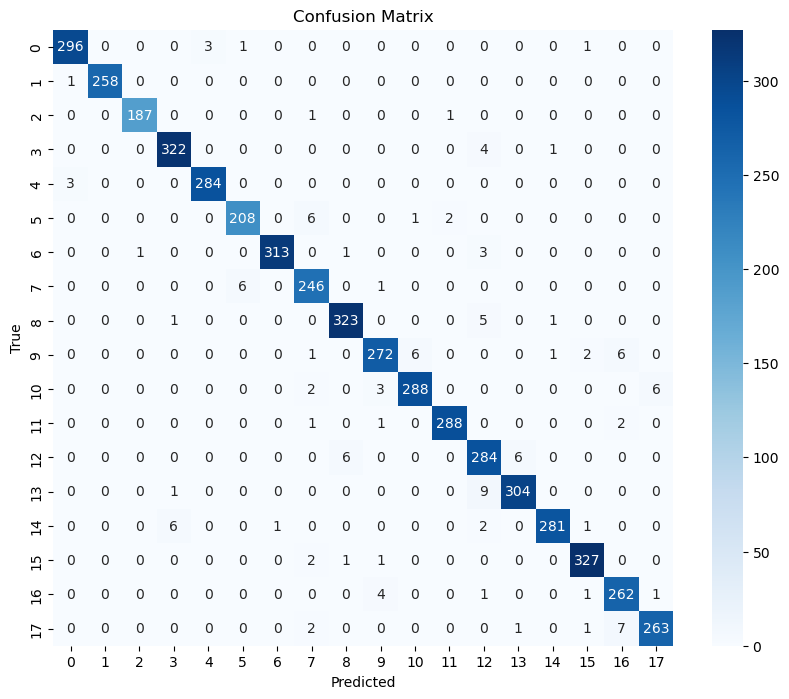

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Variant RandomForest best parameters: {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 200}
Preprocessed_Variant RandomForest test accuracy: 0.9749
Precision: 0.9750, Recall: 0.9748, F1-score: 0.9748
Inference time (ms): 207.50
Memory used (MB): 0.77
CPU usage (%): 0.60
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.98      0.98      0.98       327
           4       0.99      0.99      0.99       287
           5       0.97      0.96      0.96       217
           6       1.00      0.98      0.99       318
           7       0.94      0.97      0.96       253
           8       0.98      0.98      0.98       330
           9       0.96      0.94      0.95       288
          10       0.98      0.96      0.97  

In [74]:
%%time
print(f'Tuning Preprocessed Variant with {model_name}:')
model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed = tune_model_with_performance(X_preprocessed_train, X_preprocessed_test, y_train, y_test, variant_name="Preprocessed_Variant", model_type=model_name)

In [75]:
model_type = 'preprocessed/'

save_tuning_outputs(model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed,path+model_type)

Tuning Palm Variant with RandomForest:
Random finished
top vals: [50, 200]
competitors below: [50]
competitors above: [200]
Grid finished


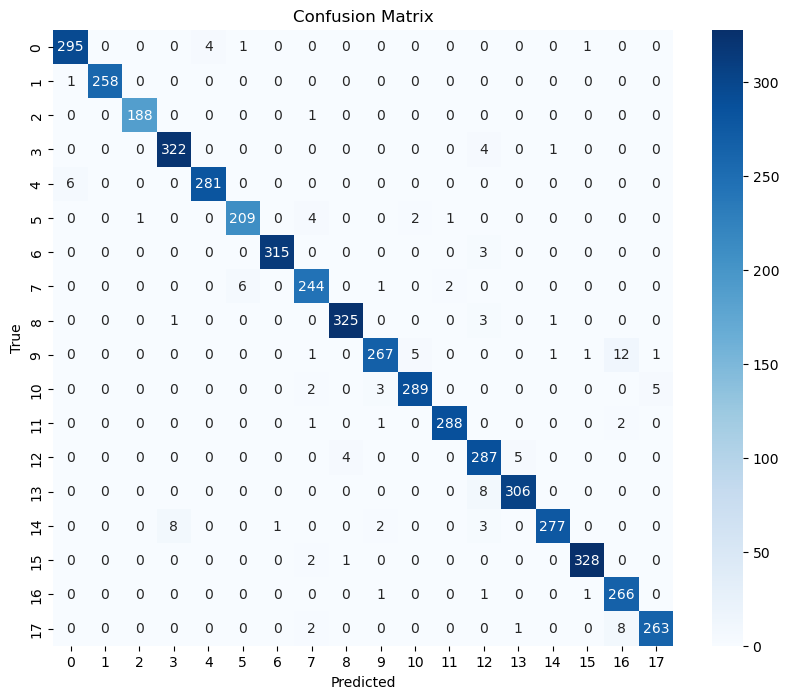

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Palm_Variant RandomForest best parameters: {'bootstrap': False, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 100}
Preprocessed_Palm_Variant RandomForest test accuracy: 0.9753
Precision: 0.9754, Recall: 0.9752, F1-score: 0.9751
Inference time (ms): 169.70
Memory used (MB): 0.00
CPU usage (%): 30.40
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.97      0.98      0.98       327
           4       0.99      0.98      0.98       287
           5       0.97      0.96      0.97       217
           6       1.00      0.99      0.99       318
           7       0.95      0.96      0.96       253
           8       0.98      0.98      0.98       330
           9       0.97      0.93      0.95       288
          10       0.98      0.97

In [76]:
%%time
print(f'Tuning Palm Variant with {model_name}:')
model_palm, params_palm, acc_palm, perf_palm = tune_model_with_performance(X_train_palm, X_test_palm, y_train, y_test, variant_name="Preprocessed_Palm_Variant", model_type=model_name)

In [77]:
model_type = 'palm/'

save_tuning_outputs(model_palm, params_palm, acc_palm, perf_palm,path+model_type)

Tuning Index Variant with RandomForest:
Random finished
top vals: [50, 200]
competitors below: [50]
competitors above: [200]
Grid finished


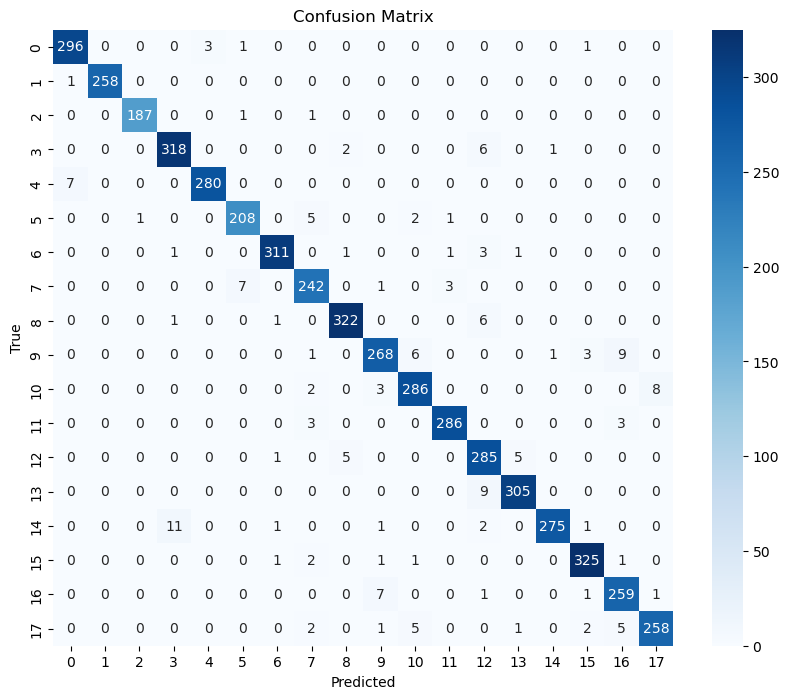

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Index_Variant RandomForest best parameters: {'bootstrap': False, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 110}
Preprocessed_Index_Variant RandomForest test accuracy: 0.9677
Precision: 0.9681, Recall: 0.9677, F1-score: 0.9678
Inference time (ms): 151.80
Memory used (MB): 0.04
CPU usage (%): 13.50
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.96      0.97      0.97       327
           4       0.99      0.98      0.98       287
           5       0.96      0.96      0.96       217
           6       0.99      0.98      0.98       318
           7       0.94      0.96      0.95       253
           8       0.98      0.98      0.98       330
           9       0.95      0.93      0.94       288
          10       0.95      0.

In [78]:
%%time
print(f'Tuning Index Variant with {model_name}:')
model_index, params_index, acc_index, perf_index = tune_model_with_performance(X_train_index, X_test_index, y_train, y_test, variant_name="Preprocessed_Index_Variant", model_type=model_name)

In [79]:
model_type = 'index/'

save_tuning_outputs(model_index, params_index, acc_index, perf_index,path+model_type)

### LogisticRegression
We genetrate the forth model of Logistic Regression classifiers

In [90]:
model_name = 'LogisticRegression'

Tuning Raw Variant with LogisticRegression:


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random finished
top vals: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors below: [0.17670169402947947, 0.008632008168602543]
competitors above: [4.0428727350273315]
top vals: [0.0006251373574521747, 0.003967605077052986, 0.008123245085588683]
competitors below: []
competitors above: [0.0006251373574521747, 0.003967605077052986, 0.008123245085588683]


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grid finished


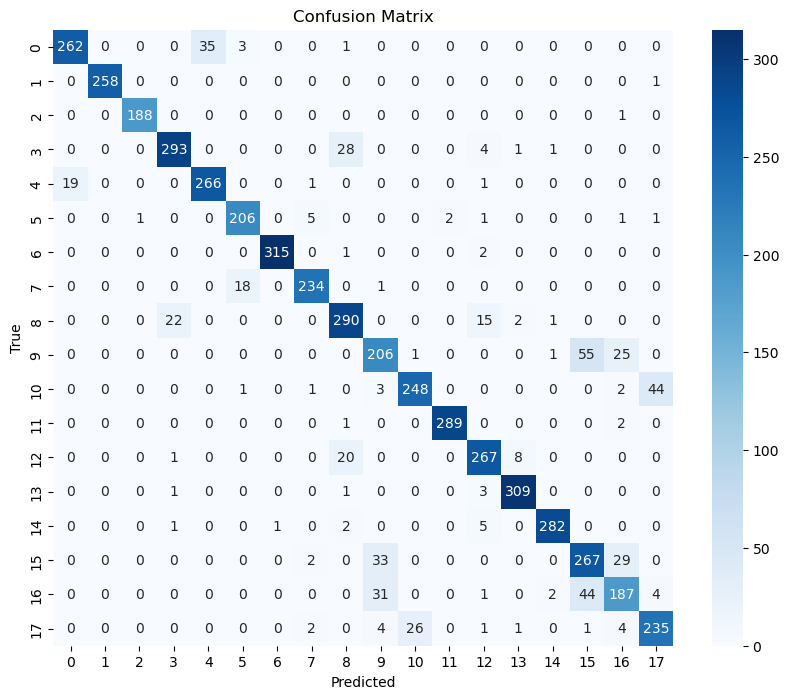

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Raw_Variant LogisticRegression best parameters: {'C': 3.943484138374522, 'class_weight': None, 'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 2.922906213564703e-05}
Raw_Variant LogisticRegression test accuracy: 0.8962
Precision: 0.8999, Recall: 0.8987, F1-score: 0.8989
Inference time (ms): 4.10
Memory used (MB): 0.10
CPU usage (%): 2.60
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.92      0.90      0.91       327
           4       0.88      0.93      0.90       287
           5       0.90      0.95      0.93       217
           6       1.00      0.99      0.99       318
           7       0.96      0.92      0.94       253
           8       0.84      0.88      0.86       330
           9       0.74      0.72      0.73       288
          10       0.90  

In [91]:
%%time
print(f'Tuning Raw Variant with {model_name}:')
model_raw, params_raw, acc_raw, perf_raw = tune_model_with_performance(X_raw_train, X_raw_test, y_train, y_test, variant_name="Raw_Variant", model_type=model_name)

In [92]:
path = 'outputs/'+model_name+'/'
model_type = 'raw/'
save_tuning_outputs(model_raw, params_raw, acc_raw, perf_raw,path+model_type)

Tuning Preprocessed Variant with LogisticRegression:


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random finished
top vals: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors below: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors above: []
top vals: [0.0006251373574521747, 0.003967605077052986, 0.008123245085588683]
competitors below: [0.0006251373574521747, 0.003967605077052986]
competitors above: [0.008123245085588683]


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grid finished


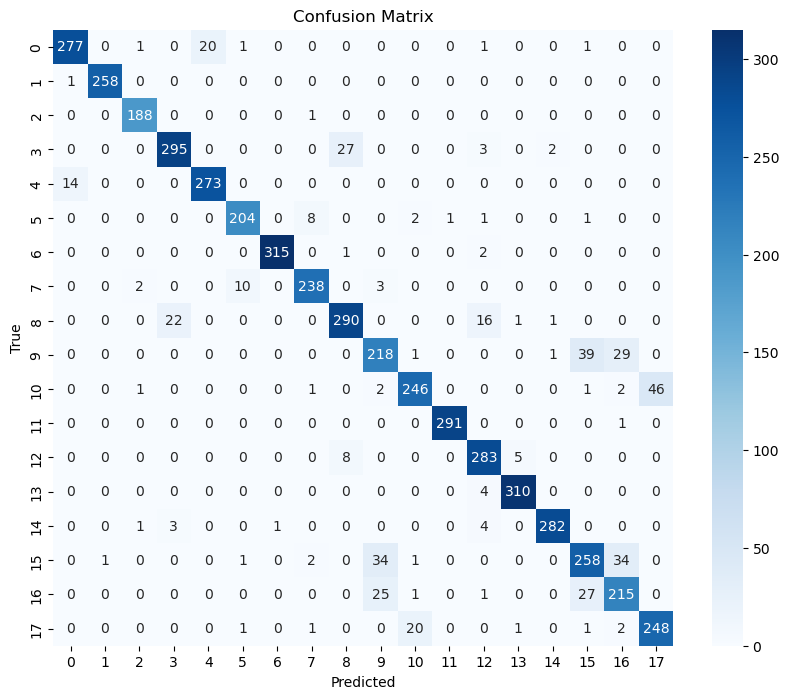

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Variant LogisticRegression best parameters: {'C': 476.8549932052648, 'class_weight': 'balanced', 'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.005246446088695264}
Preprocessed_Variant LogisticRegression test accuracy: 0.9131
Precision: 0.9154, Recall: 0.9160, F1-score: 0.9154
Inference time (ms): 4.00
Memory used (MB): 0.00
CPU usage (%): 5.90
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       301
           1       1.00      1.00      1.00       259
           2       0.97      0.99      0.98       189
           3       0.92      0.90      0.91       327
           4       0.93      0.95      0.94       287
           5       0.94      0.94      0.94       217
           6       1.00      0.99      0.99       318
           7       0.95      0.94      0.94       253
           8       0.89      0.88      0.88       330
           9       0.77      0.76      0.76    

In [93]:
%%time
print(f'Tuning Preprocessed Variant with {model_name}:')
model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed = tune_model_with_performance(X_preprocessed_train, X_preprocessed_test, y_train, y_test, variant_name="Preprocessed_Variant", model_type=model_name)

In [94]:
model_type = 'preprocessed/'
save_tuning_outputs(model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed,path+model_type)

Tuning Palm Variant with LogisticRegression:


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random finished
top vals: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors below: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors above: []
top vals: [0.0006251373574521747, 0.003967605077052986, 0.008123245085588683]
competitors below: [0.0006251373574521747, 0.003967605077052986]
competitors above: [0.008123245085588683]


C:\Users\marha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grid finished


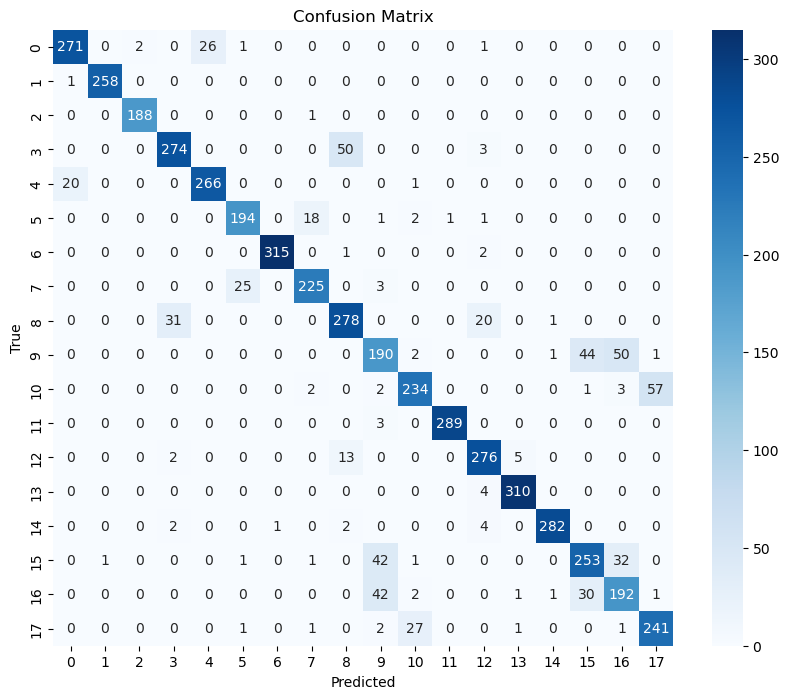

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Palm_Variant LogisticRegression best parameters: {'C': 476.8549932052648, 'class_weight': 'balanced', 'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.005246446088695264}
Preprocessed_Palm_Variant LogisticRegression test accuracy: 0.8833
Precision: 0.8862, Recall: 0.8862, F1-score: 0.8858
Inference time (ms): 5.80
Memory used (MB): 0.00
CPU usage (%): 23.70
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.89      0.84      0.86       327
           4       0.91      0.93      0.92       287
           5       0.87      0.89      0.88       217
           6       1.00      0.99      0.99       318
           7       0.91      0.89      0.90       253
           8       0.81      0.84      0.82       330
           9       0.67      0.66   

In [95]:
%%time
print(f'Tuning Palm Variant with {model_name}:')
model_palm, params_palm, acc_palm, perf_palm = tune_model_with_performance(X_train_palm, X_test_palm, y_train, y_test, variant_name="Preprocessed_Palm_Variant", model_type=model_name)

In [96]:
model_type = 'palm/'
save_tuning_outputs(model_palm, params_palm, acc_palm, perf_palm,path+model_type)

Tuning Index Variant with LogisticRegression:
Random finished
top vals: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors below: [0.17670169402947947, 0.008632008168602543, 4.0428727350273315]
competitors above: []
top vals: [0.0006251373574521747, 0.003967605077052986, 0.008123245085588683]
competitors below: [0.0006251373574521747, 0.003967605077052986]
competitors above: [0.008123245085588683]
Grid finished


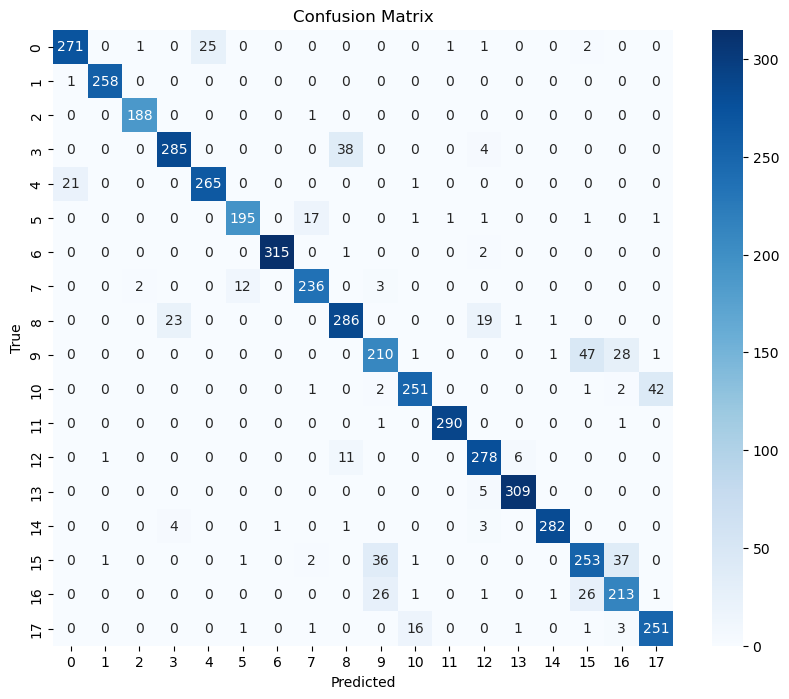

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Index_Variant LogisticRegression best parameters: {'C': 476.8549932052648, 'class_weight': 'balanced', 'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.005246446088695264}
Preprocessed_Index_Variant LogisticRegression test accuracy: 0.9028
Precision: 0.9058, Recall: 0.9056, F1-score: 0.9054
Inference time (ms): 3.80
Memory used (MB): 0.70
CPU usage (%): 3.50
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       301
           1       0.99      1.00      0.99       259
           2       0.98      0.99      0.99       189
           3       0.91      0.87      0.89       327
           4       0.91      0.92      0.92       287
           5       0.93      0.90      0.92       217
           6       1.00      0.99      0.99       318
           7       0.91      0.93      0.92       253
           8       0.85      0.87      0.86       330
           9       0.76      0.73  

In [97]:
%%time
print(f'Tuning Index Variant with {model_name}:')
model_index, params_index, acc_index, perf_index = tune_model_with_performance(X_train_index, X_test_index, y_train, y_test, variant_name="Preprocessed_Index_Variant", model_type=model_name)

In [98]:
model_type = 'index/'
save_tuning_outputs(model_index, params_index, acc_index, perf_index,path+model_type)

### XGBoost
We genetrate the fifth model of XGBoost classifiers

In [44]:
model_name = 'XGBoost'

Tuning Raw Variant with XGBoost:


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [16:22:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random finished
top vals: [0.8, 0.8, 0.8]
competitors below: [0.8, 0.8, 0.8]
competitors above: []
top vals: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors below: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors above: []
top vals: []
competitors below: []
competitors above: []
top vals: [0.8]
competitors below: [0.8]
competitors above: []


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [20:37:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Grid finished


C:\Users\marha\anaconda3\lib\site-packages\xgboost\core.py:729: UserWarning: [20:37:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


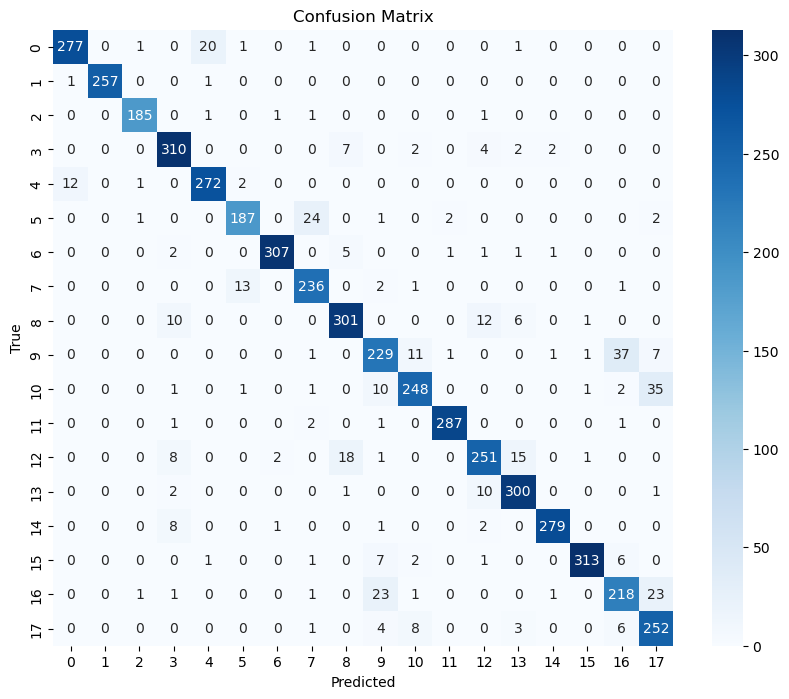

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Raw_Variant XGBoost best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.07847122217977273, 'max_depth': 9, 'n_estimators': 220, 'subsample': 0.9}
Raw_Variant XGBoost test accuracy: 0.9170
Precision: 0.9183, Recall: 0.9169, F1-score: 0.9170
Inference time (ms): 102.30
Memory used (MB): 0.52
CPU usage (%): 10.40
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       301
           1       1.00      0.99      1.00       259
           2       0.98      0.98      0.98       189
           3       0.90      0.95      0.93       327
           4       0.92      0.95      0.93       287
           5       0.92      0.86      0.89       217
           6       0.99      0.97      0.98       318
           7       0.88      0.93      0.90       253
           8       0.91      0.91      0.91       330
           9       0.82      0.80      0.81       288
          10       0.91      0.83      0.87       299
          11       0.99      

In [18]:
%%time
print(f"Tuning Raw Variant with {model_name}:")
model_raw, params_raw, acc_raw, perf_raw = tune_model_with_performance(X_raw_train, X_raw_test, y_train, y_test, variant_name="Raw_Variant", model_type="XGBoost")

In [45]:
model_type = 'raw/'
path = 'outputs/'+model_name+'/'
save_tuning_outputs(model_raw, params_raw, acc_raw, perf_raw,path+model_type)

Tuning Preprocessed Variant with XGBoost:


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [21:48:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random finished
top vals: [0.8, 0.8, 0.8]
competitors below: [0.8, 0.8, 0.8]
competitors above: []
top vals: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors below: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors above: []
top vals: []
competitors below: []
competitors above: []
top vals: [0.8]
competitors below: [0.8]
competitors above: []


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [23:48:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Grid finished


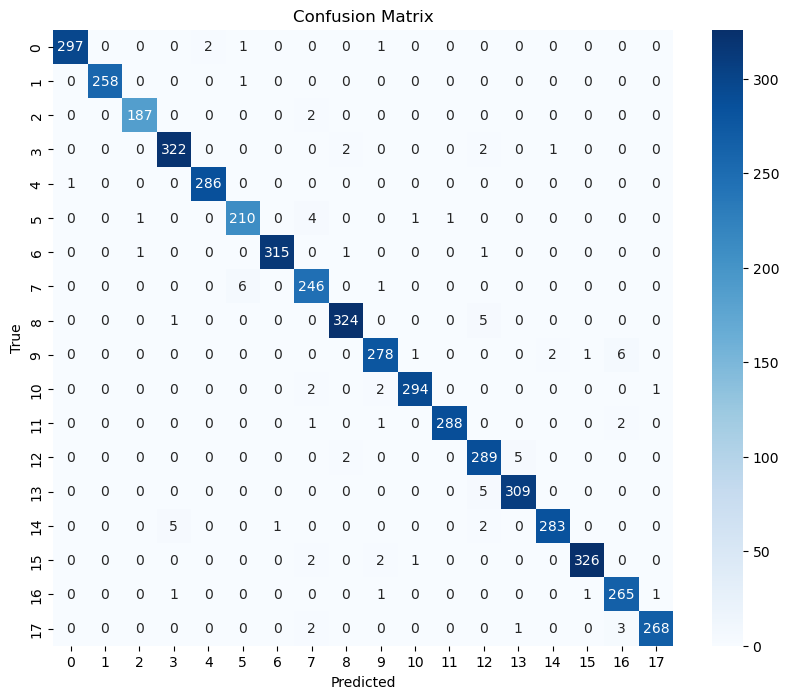

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Variant XGBoost best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.0713374747088843, 'max_depth': 9, 'n_estimators': 220, 'subsample': 0.9}
Preprocessed_Variant XGBoost test accuracy: 0.9825
Precision: 0.9822, Recall: 0.9823, F1-score: 0.9822
Inference time (ms): 87.00
Memory used (MB): 0.29
CPU usage (%): 20.30
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.98      0.98      0.98       327
           4       0.99      1.00      0.99       287
           5       0.96      0.97      0.97       217
           6       1.00      0.99      0.99       318
           7       0.95      0.97      0.96       253
           8       0.98      0.98      0.98       330
           9       0.97      0.97      0.97       288
          10       0.99      0.98      0.99       299
          11 

In [33]:
%%time
print(f"Tuning Preprocessed Variant with {model_name}:")
model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed = tune_model_with_performance(X_preprocessed_train, X_preprocessed_test, y_train, y_test, variant_name="Preprocessed_Variant", model_type="XGBoost")

In [46]:
model_type = 'preprocessed/'
save_tuning_outputs(model_preprocessed, params_preprocessed, acc_preprocessed, perf_preprocessed,path+model_type)

Tuning Palm Variant with XGBoost:


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [01:18:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random finished
top vals: [0.8, 0.8, 0.8]
competitors below: [0.8, 0.8, 0.8]
competitors above: []
top vals: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors below: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors above: []
top vals: []
competitors below: []
competitors above: []
top vals: [0.8]
competitors below: [0.8]
competitors above: []


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [02:49:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Grid finished


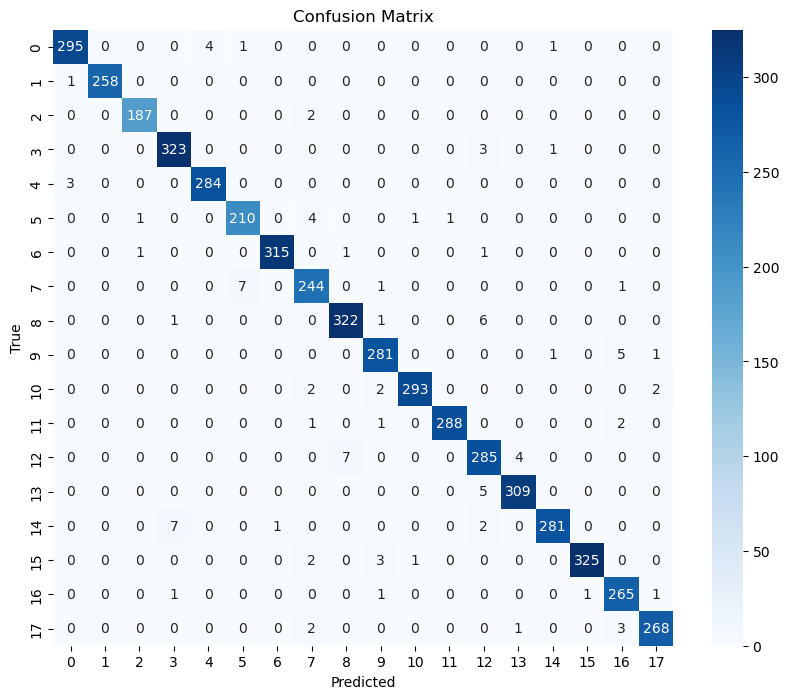

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Palm_Variant XGBoost best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.0713374747088843, 'max_depth': 9, 'n_estimators': 220, 'subsample': 0.9}
Preprocessed_Palm_Variant XGBoost test accuracy: 0.9801
Precision: 0.9799, Recall: 0.9801, F1-score: 0.9800
Inference time (ms): 80.19
Memory used (MB): 0.25
CPU usage (%): 17.80
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.97      0.99      0.98       327
           4       0.99      0.99      0.99       287
           5       0.96      0.97      0.97       217
           6       1.00      0.99      0.99       318
           7       0.95      0.96      0.96       253
           8       0.98      0.98      0.98       330
           9       0.97      0.98      0.97       288
          10       0.99      0.98      0.99       299
   

In [38]:
%%time
print(f"Tuning Palm Variant with {model_name}:")
model_palm, params_palm, acc_palm, perf_palm = tune_model_with_performance(X_train_palm, X_test_palm, y_train, y_test, variant_name="Preprocessed_Palm_Variant", model_type="XGBoost")

In [47]:
model_type = 'palm/'
save_tuning_outputs(model_palm, params_palm, acc_palm, perf_palm,path+model_type)

Tuning Index Variant with XGBoost:


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random finished
top vals: [0.8, 0.8, 0.8]
competitors below: [0.8, 0.8, 0.8]
competitors above: []
top vals: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors below: [0.039181943471417395, 0.015620693675639861, 0.00828891686688514]
competitors above: []
top vals: []
competitors below: []
competitors above: []
top vals: [0.8]
competitors below: [0.8]
competitors above: []


C:\Users\marha\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [05:37:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Grid finished


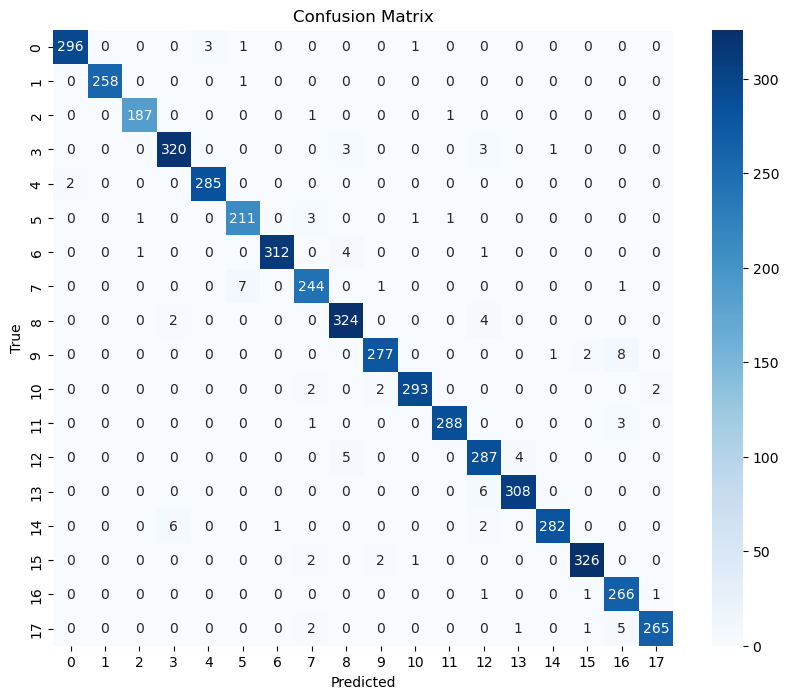

C:\Users\marha\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Preprocessed_Index_Variant XGBoost best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.06420372723799588, 'max_depth': 9, 'n_estimators': 220, 'subsample': 0.9}
Preprocessed_Index_Variant XGBoost test accuracy: 0.9794
Precision: 0.9793, Recall: 0.9794, F1-score: 0.9793
Inference time (ms): 79.80
Memory used (MB): 0.59
CPU usage (%): 16.50
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       301
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       189
           3       0.98      0.98      0.98       327
           4       0.99      0.99      0.99       287
           5       0.96      0.97      0.97       217
           6       1.00      0.98      0.99       318
           7       0.96      0.96      0.96       253
           8       0.96      0.98      0.97       330
           9       0.98      0.96      0.97       288
          10       0.99      0.98      0.98       299


In [39]:
%%time
print(f"Tuning Index Variant with {model_name}:")
model_index, params_index, acc_index, perf_index = tune_model_with_performance(X_train_index, X_test_index, y_train, y_test, variant_name="Preprocessed_Index_Variant", model_type="XGBoost")

In [48]:
model_type = 'index/'
save_tuning_outputs(model_index, params_index, acc_index, perf_index,path+model_type)

# Conclusion

We finish our project by doing a quick comaprison of the different metrics and what can we deduce from them

Those are our functions that we are going to use throught this conclusion

In [30]:
def load_filtered_outputs_with_time(base_dir="outputs", model_filter="all", variant_filter="all", time_info_path="outputs/time_info.json"):
    """
    Traverse the directory hierarchy (base_dir/model_name/variant/) and load each model’s output.
    Each folder is expected to contain a performance metrics file (JSON or TXT) that includes various metrics,
    including "accuracy", "f1_score", etc.
    
    Additionally, this function loads a time_info JSON file and extracts the CPU and Wall times for each (model, variant)
    pair. It then adds two keys ("CPU_time" and "Wall_time") to the performance dictionary.
    
    Parameters:
      base_dir (str): Root directory containing outputs.
      model_filter (list or str): Either "all" or a list (or single string) of model names to include.
      variant_filter (list or str): Either "all" or a list (or single string) of data variants to include.
      time_info_path (str): Path to the JSON file with time information.
    
    Returns:
      outputs_dict (dict): Keys are tuples (model_name, variant). Values are dicts:
           {
               'model': loaded model,
               'performance': performance metrics dictionary (augmented with "CPU_time" and "Wall_time" if available)
           }
    """
    if os.path.exists(time_info_path):
        with open(time_info_path, "r") as f:
            time_info = json.load(f)
    else:
        time_info = {}
    
    outputs_dict = {}
    pattern = os.path.join(base_dir, "*", "*")
    for subdir in glob.glob(pattern):
        parts = os.path.normpath(subdir).split(os.sep)
        if len(parts) < 3:
            continue
        model_name = parts[-2]
        variant = parts[-1]
        
        # Filter by model_filter.
        if model_filter != "all":
            if isinstance(model_filter, list):
                if model_name not in model_filter:
                    continue
            else:
                if model_name != model_filter:
                    continue
        
        # Filter by variant_filter.
        if variant_filter != "all":
            if isinstance(variant_filter, list):
                if variant not in variant_filter:
                    continue
            else:
                if variant != variant_filter:
                    continue
        
        key = (model_name, variant)
        loaded = {}
        
        model_file = os.path.join(subdir, "best_model.pkl")
        loaded["model"] = None
        if os.path.exists(model_file):
            with open(model_file, "rb") as f:
                loaded["model"] = pickle.load(f)
        
        perf_file = os.path.join(subdir, "performance_metrics.json")
        if not os.path.exists(perf_file):
            perf_file = os.path.join(subdir, "performance_metrics.txt")
        perf_data = {}
        if os.path.exists(perf_file):
            try:
                with open(perf_file, "r") as f:
                    perf_data = json.load(f)
            except Exception:
                with open(perf_file, "r") as f:
                    try:
                        val = float(f.read().strip())
                        perf_data = {"accuracy": val}
                    except:
                        perf_data = {}
        
        cpu_key = f"{model_name} {variant} CPU times: total"
        wall_key = f"{model_name} {variant} Wall time"
        if cpu_key in time_info:
            perf_data["CPU_time"] = convert_time_to_seconds(time_info[cpu_key])
        if wall_key in time_info:
            perf_data["Wall_time"] = convert_time_to_seconds(time_info[wall_key])
        
        loaded["performance"] = perf_data
        outputs_dict[key] = loaded
        
    print(f"Loaded {len(outputs_dict)} outputs from directory.")
    return outputs_dict


def create_full_metrics_table(outputs_dict, sort_metric="accuracy", ascending=False, verbose=True):
    """
    Creates a full metrics table with one row per (model, variant) and all available metrics.
    Sorts the table based on the selected metric in the specified order.
    
    Parameters:
      outputs_dict (dict): Dictionary of model outputs.
      sort_metric (str): Metric to sort by.
      ascending (bool): Sorting order.
      verbose (bool): Whether to print the table.
    """
    records = []
    for (model, variant), data in outputs_dict.items():
        row = {"Model": model, "Variant": variant}
        row.update({k: v for k, v in data.get("performance", {}).items()})
        records.append(row)

    df = pd.DataFrame(records)

    if sort_metric not in df.columns:
        print(f"Sort metric '{sort_metric}' not found in the data.")
        return df

    df = df.sort_values(by=sort_metric, ascending=ascending).reset_index(drop=True)

    metric_cols = [col for col in df.columns if col not in ['Model', 'Variant']]
    metric_cols = [sort_metric] + [col for col in metric_cols if col != sort_metric]
    ordered_cols = ['Model', 'Variant'] + metric_cols
    df = df[ordered_cols]

    if verbose:
        print(f"\n{sort_metric.capitalize()} Table ({'Ascending' if ascending else 'Descending'}):")
        print(df.to_string(index=False))

    return df


def plot_metric_heatmap(df, metric_key="accuracy", ascending=False):
    """
    Creates a heatmap for the selected metric from the full metrics table.

    Parameters:
      outputs_dict (dict): Dictionary with keys (model, variant) and values containing performance metrics.
      metric_key (str): The metric to display in the heatmap.
      ascending (bool): Sorting order for the table.
    """
    pivot_df = df.pivot(index="Model", columns="Variant", values=metric_key)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, cmap="viridis", fmt=".3f", cbar_kws={"label": metric_key.capitalize()})
    plt.title(f"{metric_key.capitalize()} Heatmap")
    plt.xlabel("Data Variant")
    plt.ylabel("Model Type")
    plt.show()

def convert_time_to_seconds(time_str):
    """
    Converts a time string such as "1h 22min 2s" or "30.2 s" to total seconds (float).
    """
    seconds = 0.0
    match = re.search(r"(\d+(?:\.\d+)?)\s*h", time_str)
    if match:
        seconds += float(match.group(1)) * 3600
    match = re.search(r"(\d+(?:\.\d+)?)\s*min", time_str)
    if match:
        seconds += float(match.group(1)) * 60
    match = re.search(r"(\d+(?:\.\d+)?)\s*s", time_str)
    if match:
        seconds += float(match.group(1))
    return seconds

def plot_metric_barplot(df, metric_key="accuracy", ascending=False):
    """
    Plots a horizontal barplot for the selected metric with value labels at the end of bars.
    Fixes seaborn warning by using hue and disabling legend.
    Dynamically adjusts label position based on value range.
    """
    df["Model (Variant)"] = df["Model"] + " (" + df["Variant"] + ")"
    df_sorted = df.sort_values(metric_key, ascending=ascending)

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        y="Model (Variant)",
        x=metric_key,
        hue="Model (Variant)",
        data=df_sorted,
        palette="viridis",
        legend=False
    )

    # Determine a dynamic offset based on metric range
    offset = (df_sorted[metric_key].max() - df_sorted[metric_key].min()) * 0.01

    for i, row in enumerate(df_sorted.itertuples()):
        ax.text(
            getattr(row, metric_key) + offset,
            i,
            f"{getattr(row, metric_key):.3f}",
            va='center',
            ha='left',
            fontsize=10
        )

    ax.set_title(f"{metric_key.replace('_', ' ').capitalize()} Barplot")
    ax.set_xlabel(metric_key.replace('_', ' ').capitalize())
    ax.set_ylabel("Model (Variant)")
    plt.tight_layout()
    plt.show()


def plot_grouped_barplot(df, metric_key="accuracy", group_by="Model"):
    """
    Plots a grouped barplot for the selected metric, grouped by 'Model' or 'Variant'.
    
    Parameters:
        outputs_dict (dict): Model/variant performance dictionary.
        metric_key (str): Metric to display.
        group_by (str): Either 'Model' or 'Variant' to group the bars by.
    """
    if group_by not in ["Model", "Variant"]:
        raise ValueError("group_by must be 'Model' or 'Variant'")
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, x=group_by, y=metric_key, hue="Variant" if group_by == "Model" else "Model", palette="viridis")
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=9)

    ax.set_title(f"{metric_key.capitalize()} Grouped by {group_by}")
    ax.set_ylabel(metric_key.capitalize())
    ax.set_xlabel(group_by)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_model_ranking(df, metric_key="accuracy", group_by="Model", ascending=False):
    """
    Aggregate the specified metric over variants (by averaging) for each model and plot a ranking.
    """

    avg_df = df.groupby(group_by)[metric_key].mean().reset_index()
    avg_df = avg_df.sort_values(metric_key, ascending=ascending)
    #print(avg_df)
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=avg_df, x=group_by, y=metric_key)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=9)
    plt.title(f"Model Ranking by {metric_key.capitalize()}")
    plt.xlabel(metric_key.capitalize())
    plt.ylabel("Model")
    plt.show()


First, we visualize all the different perfromance metrics in a dataframe, sorted by the accuracy column in descending order

In [31]:
outputs_dict = load_filtered_outputs_with_time()

metrics_df = create_full_metrics_table(outputs_dict, sort_metric="accuracy", ascending=False, verbose=False)
metrics_df

Loaded 20 outputs from directory.


Model       Variant  accuracy  inference_time_ms  \
0              XGBoost  preprocessed  0.982473          86.996317   
1                  SVM  preprocessed  0.980526        2070.799923   
2              XGBoost          palm  0.980136          80.194736   
3              XGBoost         index  0.979357          79.795265   
4                  SVM          palm  0.979163        2274.699879   
5         RandomForest          palm  0.975268         169.702196   
6         RandomForest  preprocessed  0.974878         207.499933   
7                  SVM         index  0.970789        2743.900776   
8         RandomForest         index  0.967673         151.803446   
9         DecisionTree  preprocessed  0.944888           5.402589   
10        DecisionTree          palm  0.941967           3.100133   
11                 SVM           raw  0.933982         801.600027   
12        DecisionTree         index  0.928724           3.099990   
13             XGBoost           raw  0.917040         102.296758   
14  LogisticRegression  preprocessed  0.913145           4.002261   
15  LogisticRegression         index  0.902824           3.800178   
16  LogisticRegression           raw  0.896203           4.096746   
17  LogisticRegression          palm  0.883350           5.800080   
18        RandomForest           raw  0.839533         322.596335   
19        DecisionTree           raw  0.550536           3.300238   

    memory_used_mb  cpu_usage_percent  precision    recall  f1_score  \
0         0.289062               20.3   0.982156  0.982326  0.982201   
1         0.007812                1.3   0.980208  0.980446  0.980220   
2         0.246094               17.8   0.979926  0.980056  0.979952   
3         0.589844               16.5   0.979325  0.979377  0.979271   
4         0.003906                3.5   0.978760  0.979046  0.978767   
5         0.000000               30.4   0.975392  0.975182  0.975139   
6         0.765625                0.6   0.975038  0.974782  0.974838   
7         0.132812               10.8   0.970948  0.971251  0.970904   
8         0.042969               13.5   0.968092  0.967658  0.967766   
9         1.382812               16.3   0.946223  0.945108  0.945423   
10        0.078125               13.7   0.942763  0.942688  0.942609   
11        0.089844                0.0   0.934800  0.935251  0.934910   
12        0.003906               22.1   0.930879  0.930744  0.930476   
13        0.515625               10.4   0.918304  0.916919  0.916970   
14        0.003906                5.9   0.915375  0.915952  0.915366   
15        0.703125                3.5   0.905848  0.905616  0.905386   
16        0.101562                2.6   0.899940  0.898710  0.898874   
17        0.000000               23.7   0.886154  0.886153  0.885792   
18      210.332031                5.6   0.842220  0.840552  0.839968   
19        0.355469                1.0   0.571325  0.553129  0.555871   

    CPU_time  Wall_time  
0      55.20     8093.0  
1      30.20      250.0  
2      49.10     5885.0  
3      51.20     6327.0  
4      30.80      246.0  
5      38.30      460.0  
6      66.00      612.0  
7      36.30      260.0  
8      38.60      547.0  
9       5.11       20.4  
10      3.52       14.7  
11   4922.00    37823.0  
12      3.91       16.3  
13     89.00    16416.0  
14    541.00     1946.0  
15    479.00     1604.0  
16    610.00     5236.0  
17    516.00     1589.0  
18     84.00      720.0  
19      2.36       18.3

### Accuracy
We first visualisze the accuracy of the different models in different graphs to analyse it.

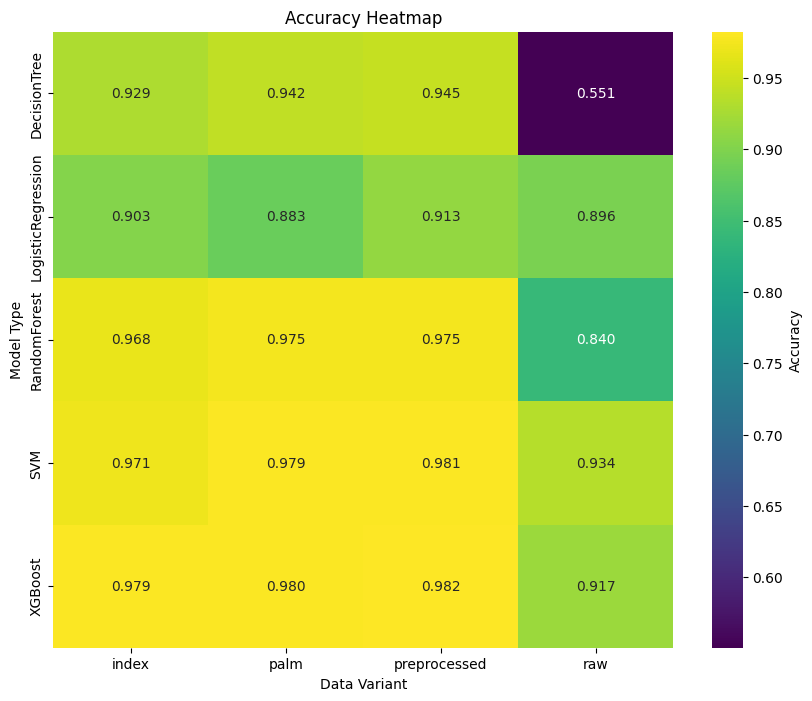

In [32]:
plot_metric_heatmap(metrics_df, metric_key="accuracy")

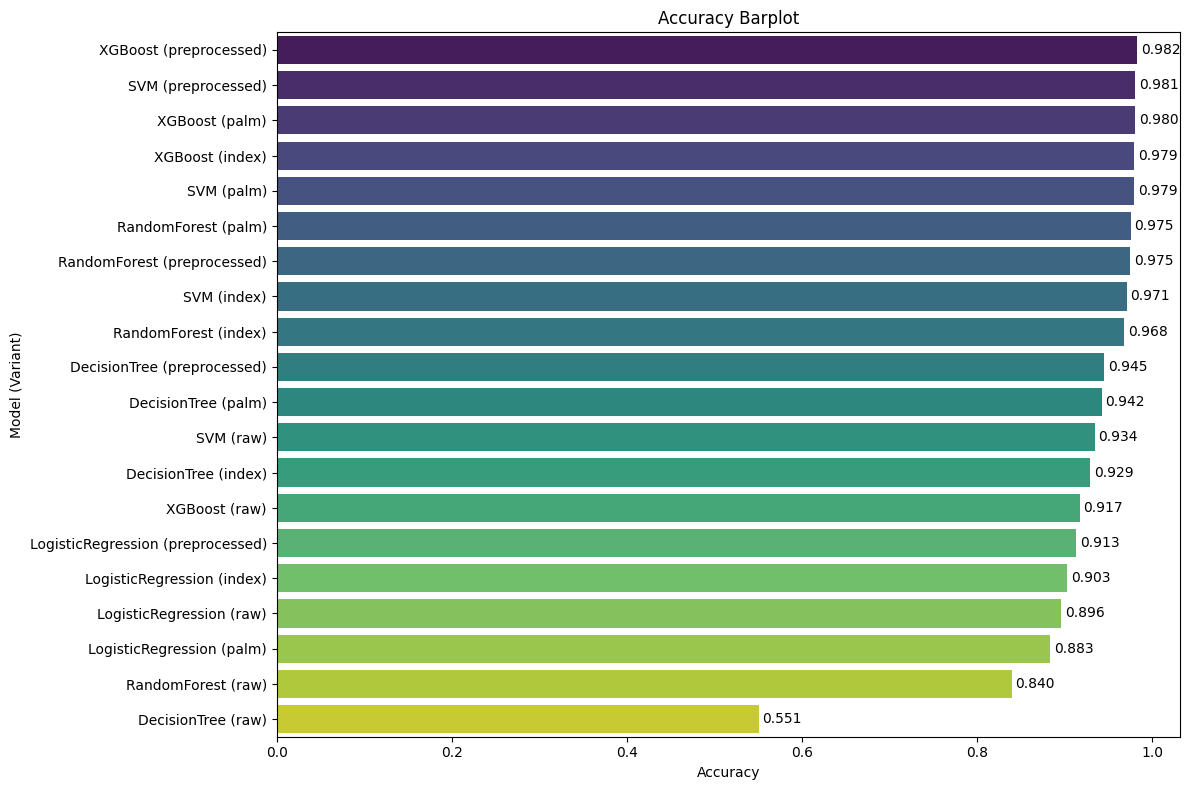

In [33]:
plot_metric_barplot(metrics_df, metric_key="accuracy", ascending=False)

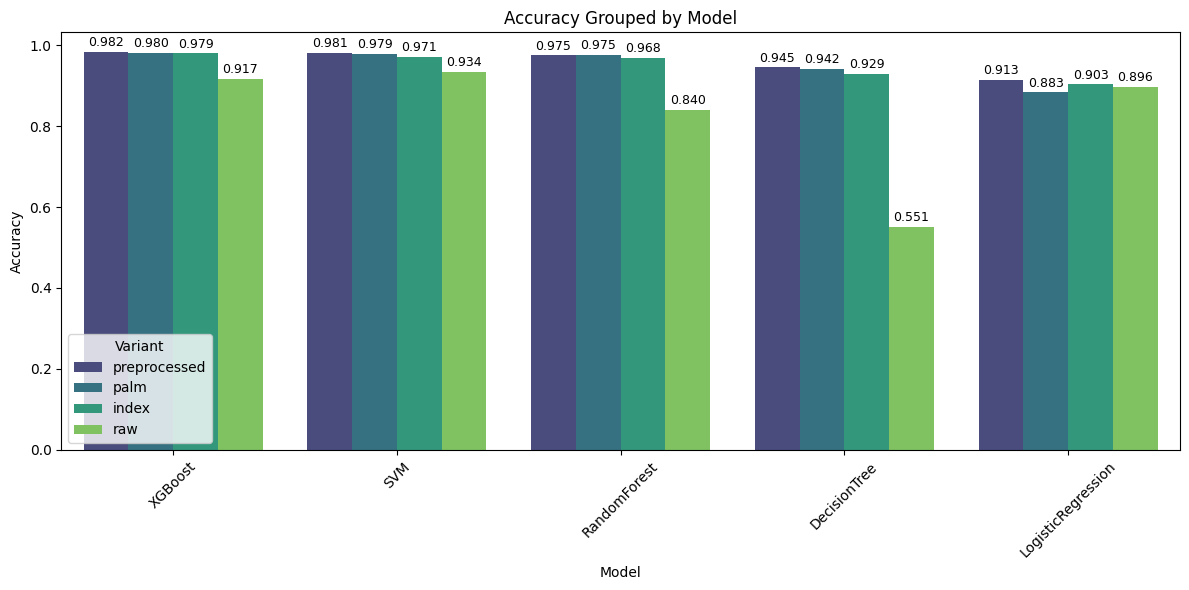

In [34]:
plot_grouped_barplot(metrics_df, metric_key="accuracy", group_by="Model")

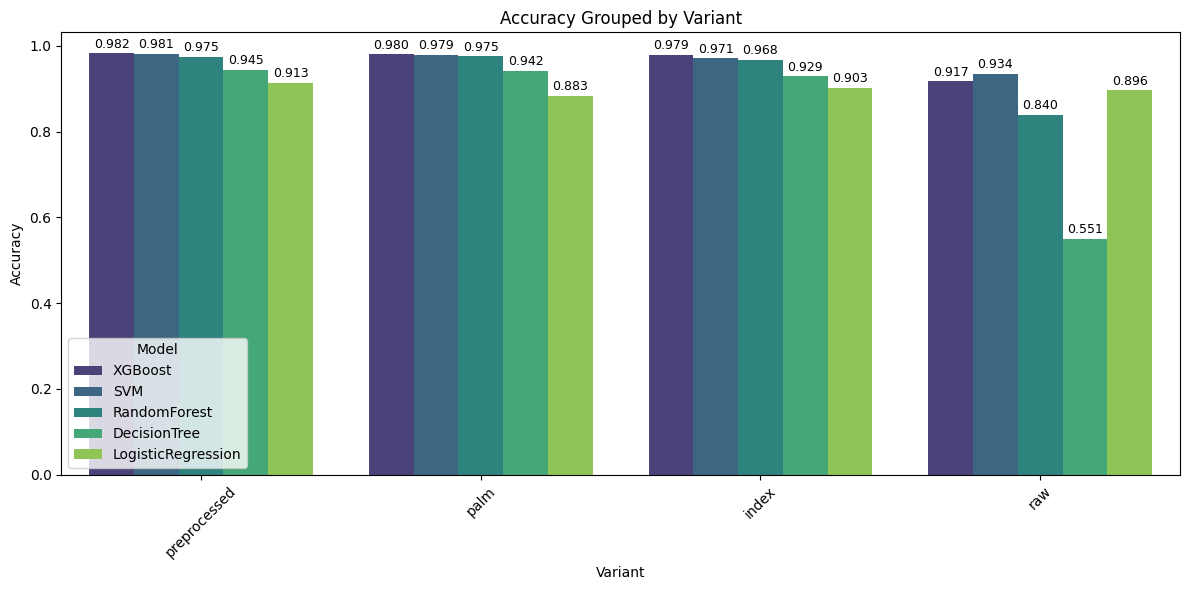

In [35]:
plot_grouped_barplot(metrics_df, metric_key="accuracy", group_by="Variant")

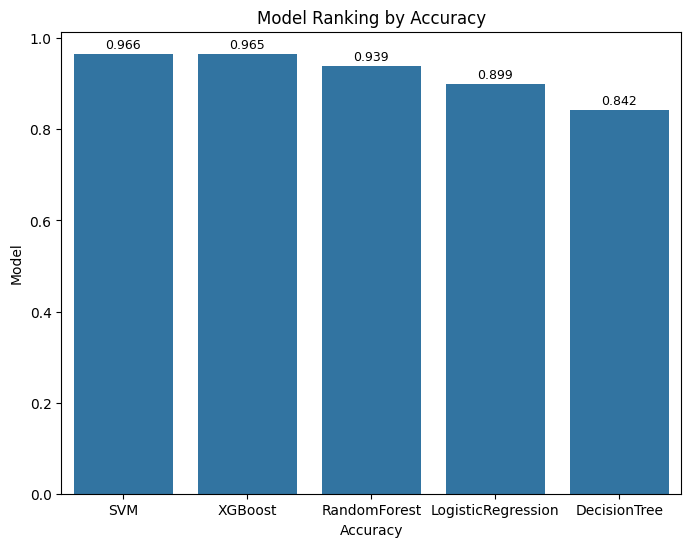

In [36]:
plot_model_ranking(metrics_df, metric_key="accuracy", group_by="Model")

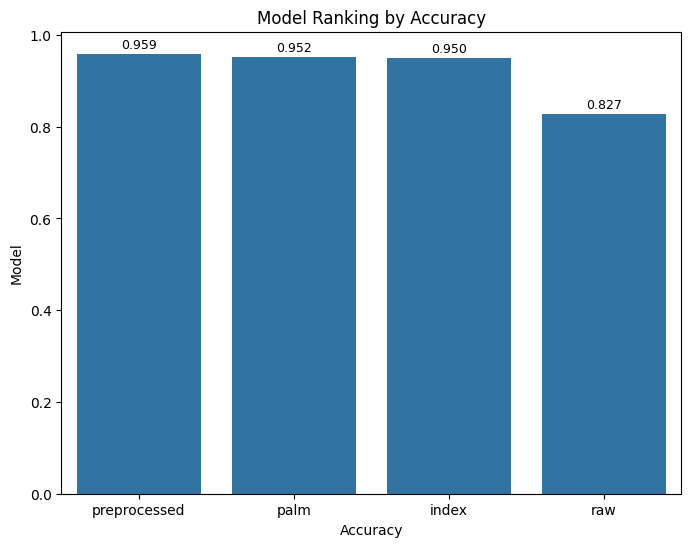

In [37]:
plot_model_ranking(metrics_df, metric_key="accuracy", group_by="Variant")

From these graphs, the best model using accuracy as a criteria is XGBoost with preprocessed dataset, however, we have to note that the accuracy of the SVM model with preprocessed dataset is quite similar with XGBoost with a small difference in accuracy

Overall, when we take the aveage of all different dataset variants, the SVM model is the best, and comes after it directly the XGBoost, while if we take the aveage of all different models for each dataset variants, the preprocessed variant achived the heighest accuracy, and comes after it the preprocessed palm variant, and shortly the third preprocessed index variant, and the raw data achived the worst accuracy. Also this shows that we can replace the whole preprocessed dataset with one that had dropped various columns like when we did with the preprocessed palm variant, to reduce the curse of dimensionality and speed up the training process

### F1-score
We also visualisze the F1-score of the different models because the dataset is a bit imbalanced to know about the performanceof the models.

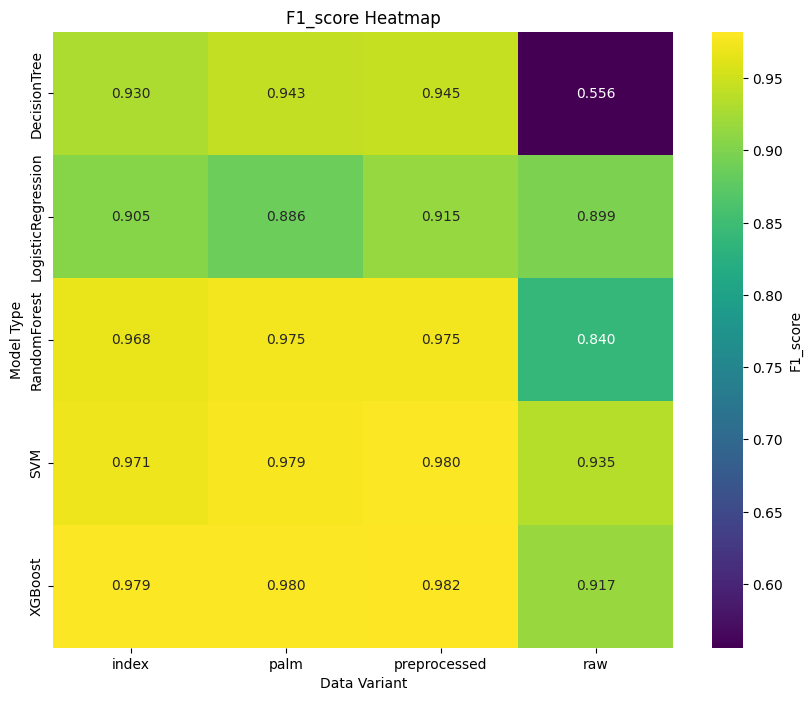

In [38]:
plot_metric_heatmap(metrics_df, metric_key="f1_score")

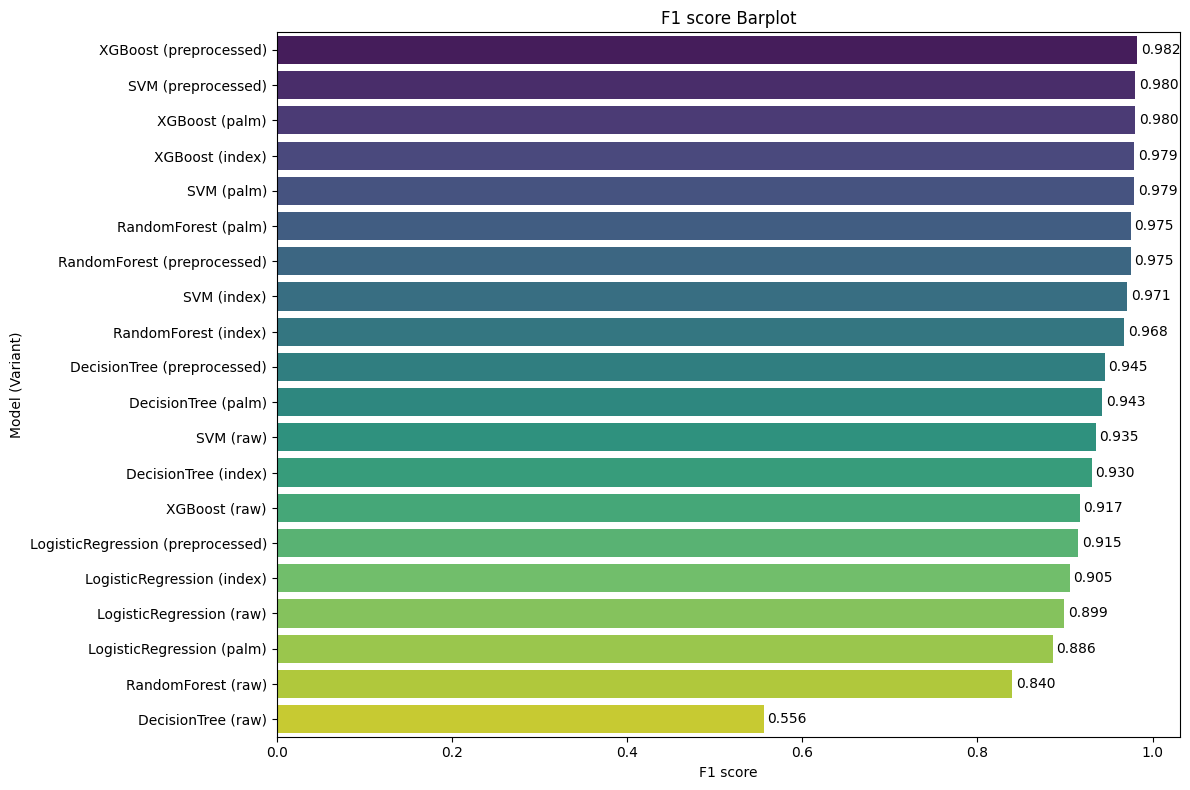

In [39]:
plot_metric_barplot(metrics_df, metric_key="f1_score", ascending=False)

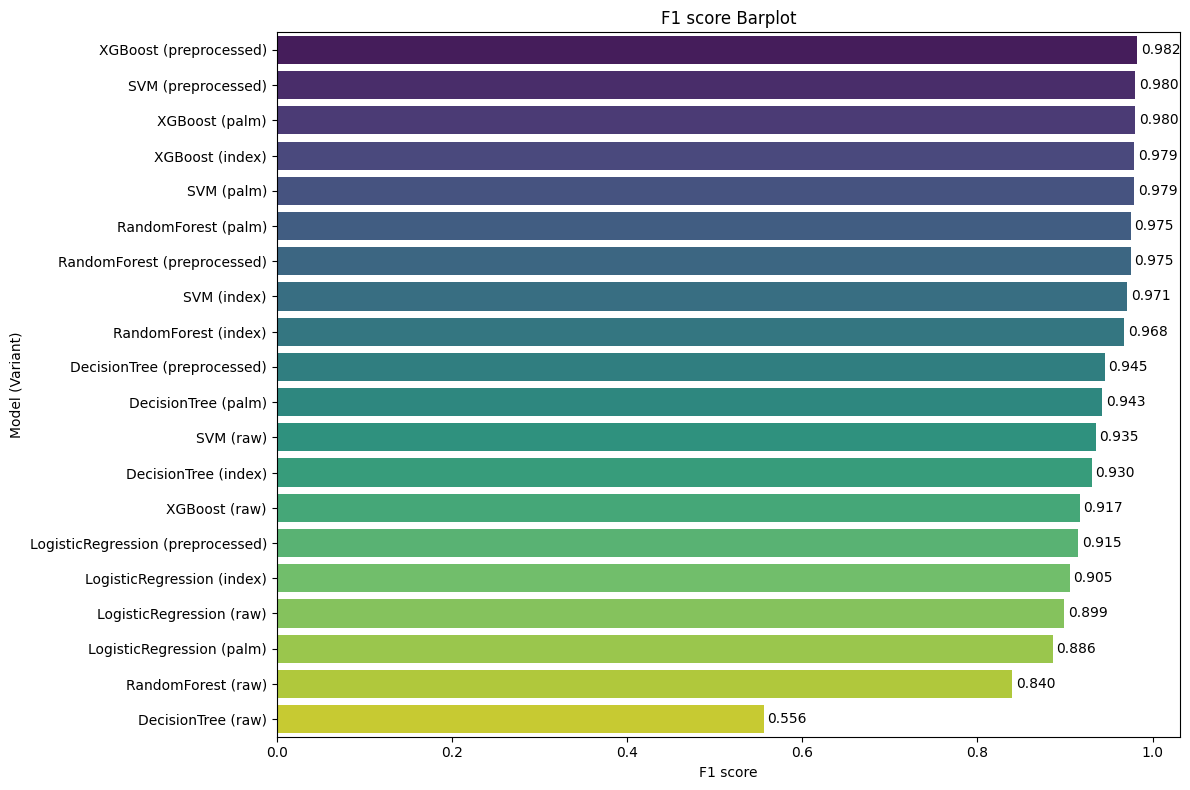

In [40]:
plot_metric_barplot(metrics_df, metric_key="f1_score", ascending=False)

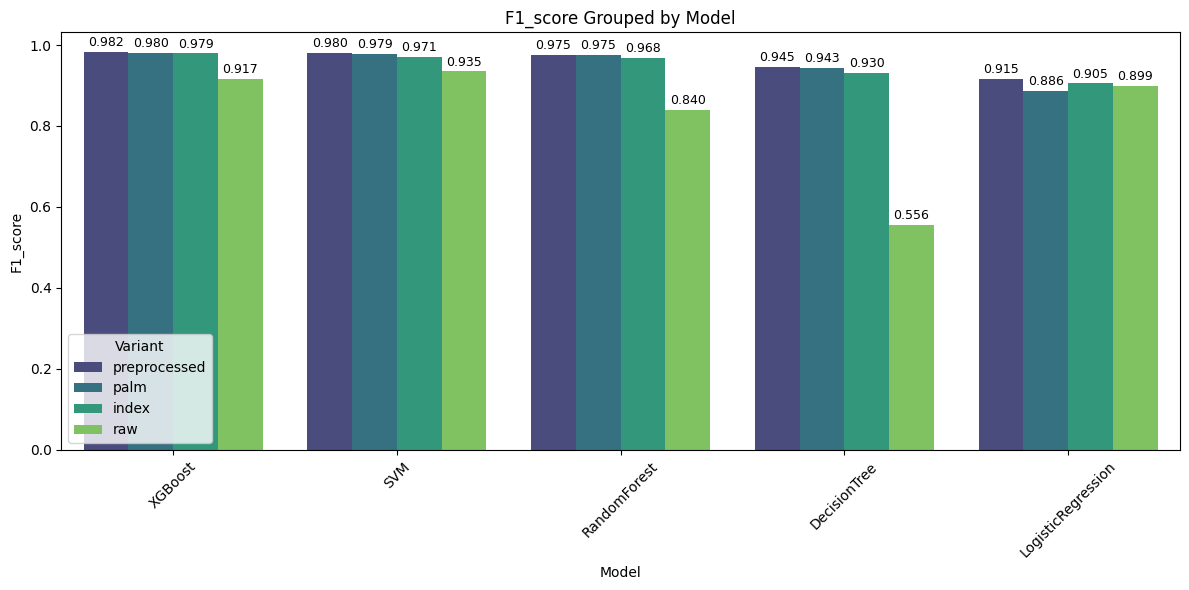

In [41]:
plot_grouped_barplot(metrics_df, metric_key="f1_score", group_by="Model")

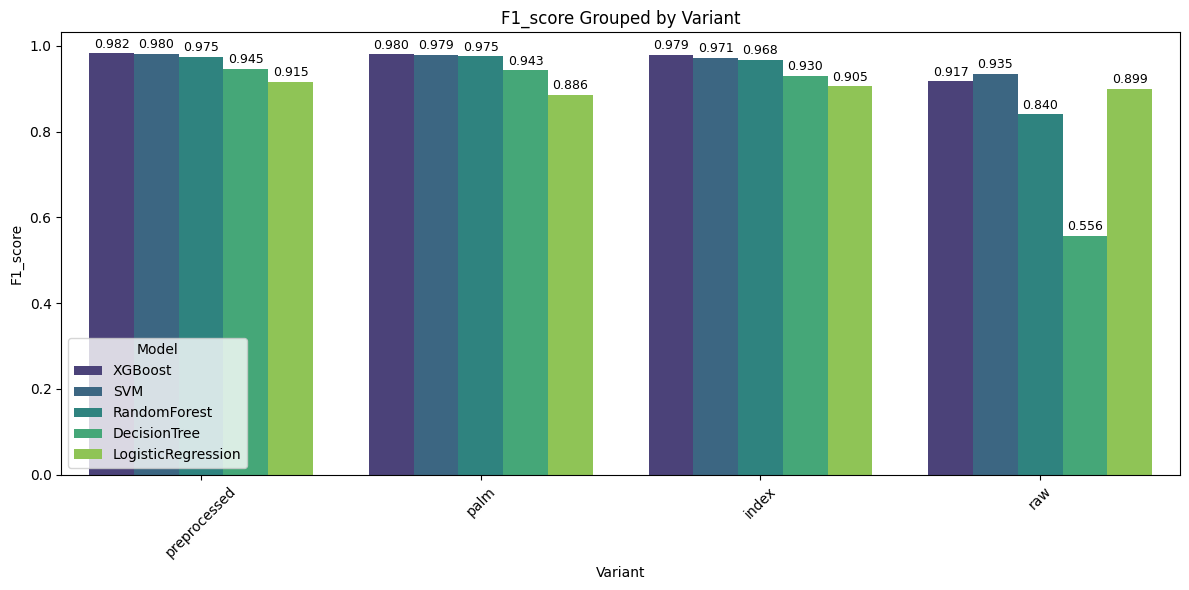

In [42]:
plot_grouped_barplot(metrics_df, metric_key="f1_score", group_by="Variant")

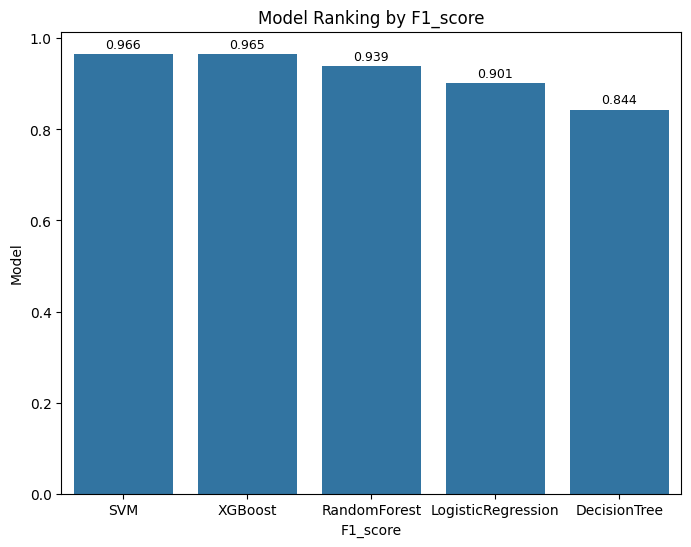

In [43]:
plot_model_ranking(metrics_df, metric_key="f1_score", group_by="Model")

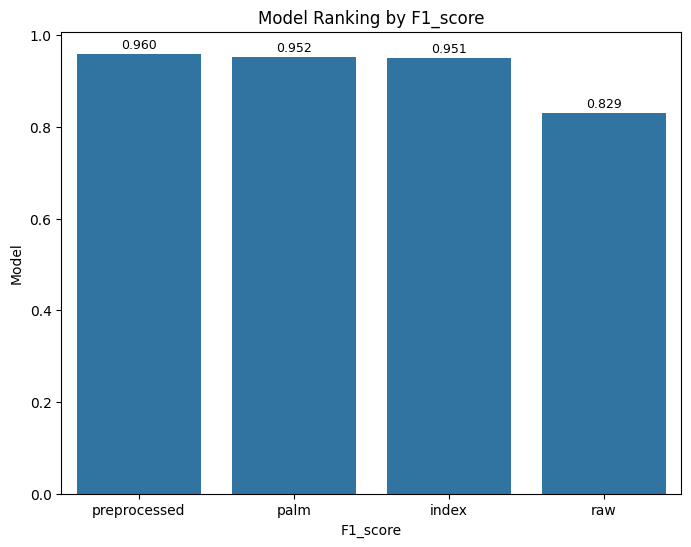

In [44]:
plot_model_ranking(metrics_df, metric_key="f1_score", group_by="Variant")

It seems that there is no significant difference between using the accuracy score or the f1-score, because it has yielded the same observations.

### Inference Time	
We now see how long does it usually take a mdel to infer a new data point in order to make prediction

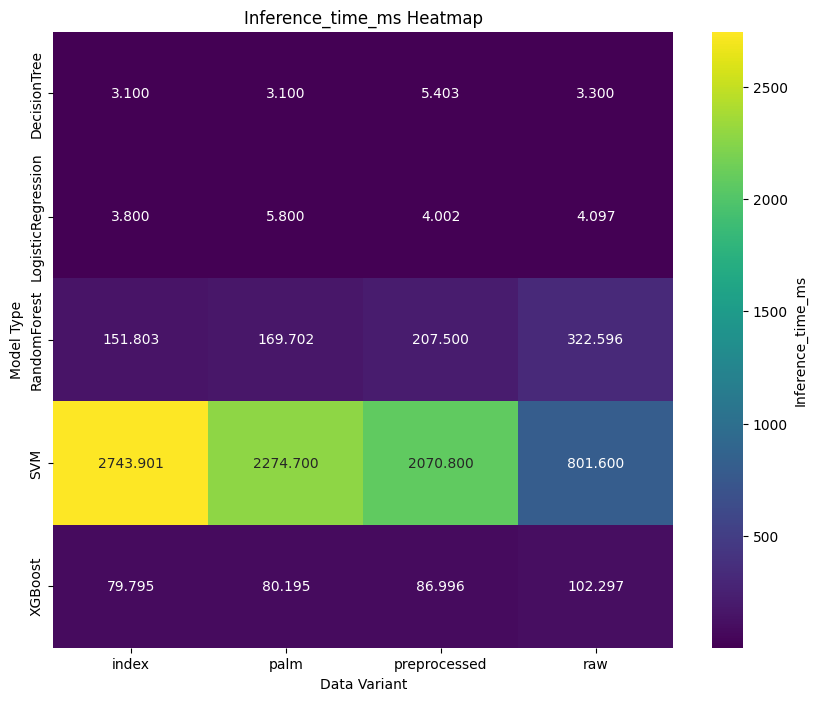

In [45]:
plot_metric_heatmap(metrics_df, metric_key="inference_time_ms")

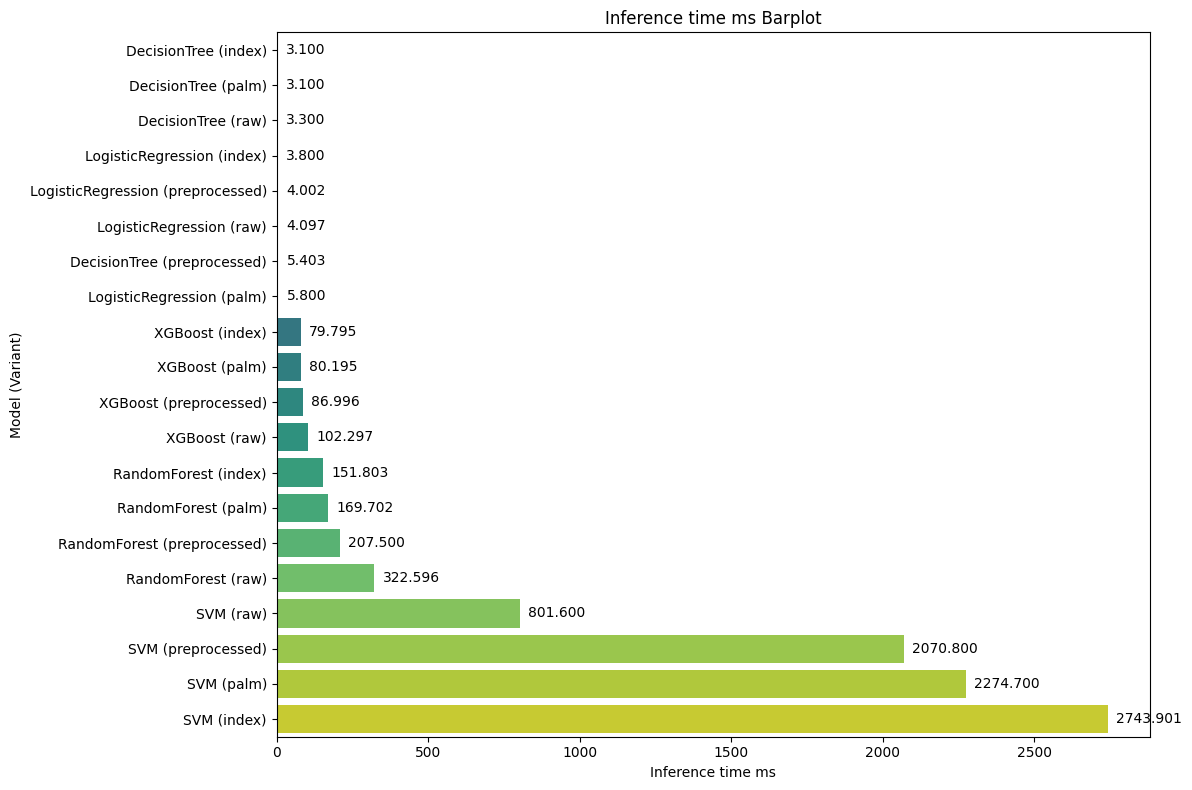

In [46]:
plot_metric_barplot(metrics_df, metric_key="inference_time_ms", ascending=True)

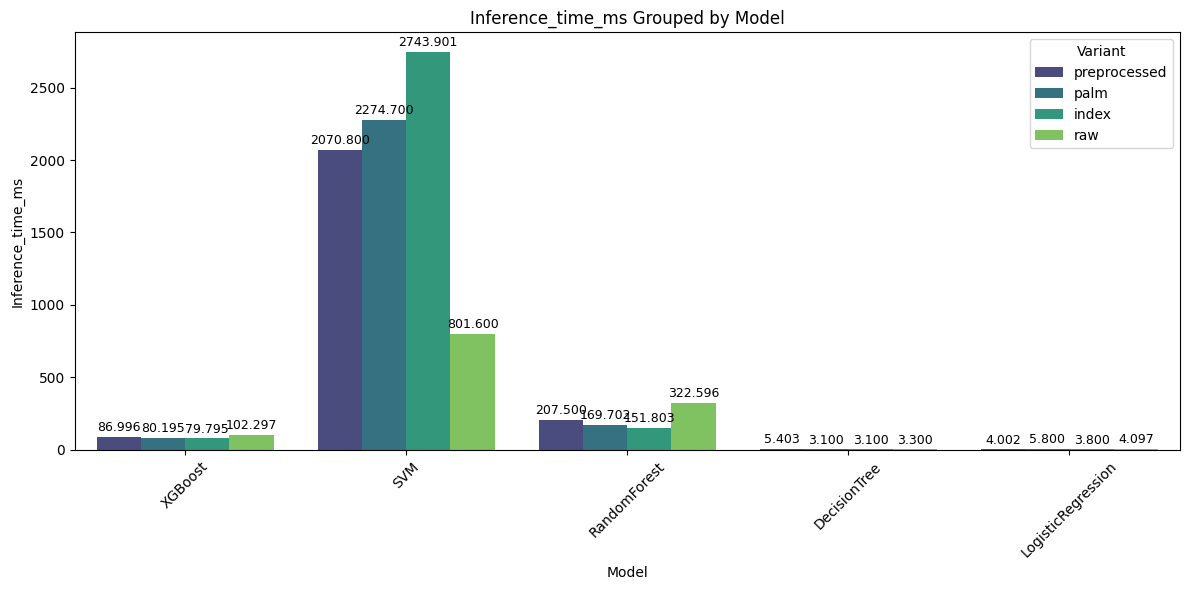

In [47]:
plot_grouped_barplot(metrics_df, metric_key="inference_time_ms", group_by="Model")

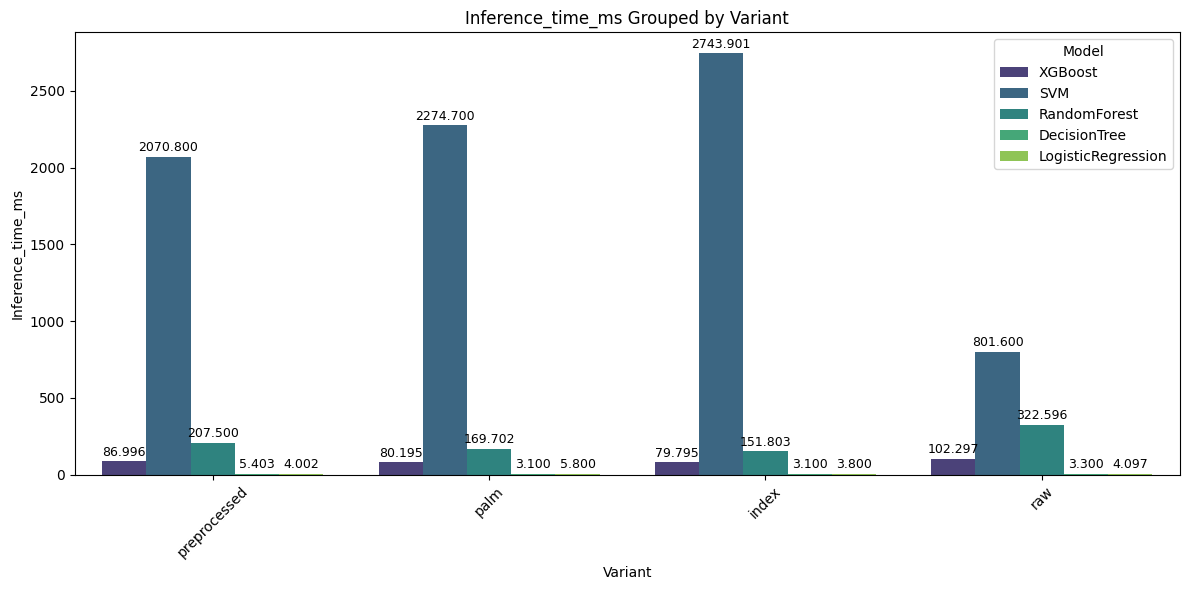

In [48]:
plot_grouped_barplot(metrics_df, metric_key="inference_time_ms", group_by="Variant")

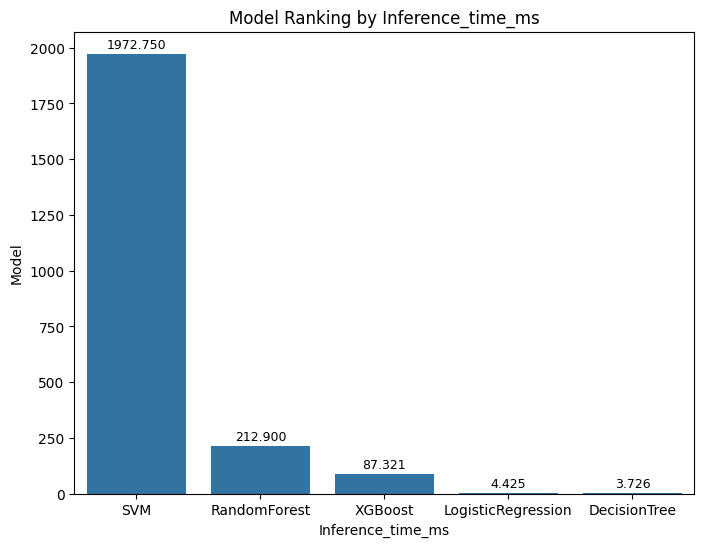

In [49]:
plot_model_ranking(metrics_df, metric_key="inference_time_ms", group_by="Model")

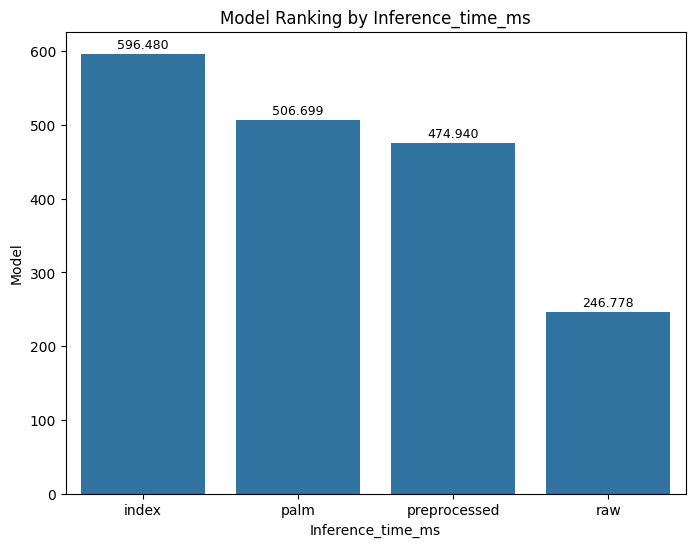

In [50]:
plot_model_ranking(metrics_df, metric_key="inference_time_ms", group_by="Variant")

From the graphs, the SVM models has the biggest inference time, and it can reach to near 2 seconds in order to classify a data point, which makes it unsuitable for any application that requires live feedback. While XGBoost is intermediate value taking around 87 milliseconds, and finally the Logistic Regression and the Decision Tree are almost instantaneous which makes them suitable to any application that requires a moderate accuracy but must have a fast decision

While, the classification by vaiant, they have almost similar time for all the models, except at the SVM, where the raw dataset has the lowest inference time in comparison to the other variants, and at random forest it has the highest one 

### CPU usage	
We now see how much CPU usage does it usually take a mdel in order to infer a new data point in order to make prediction

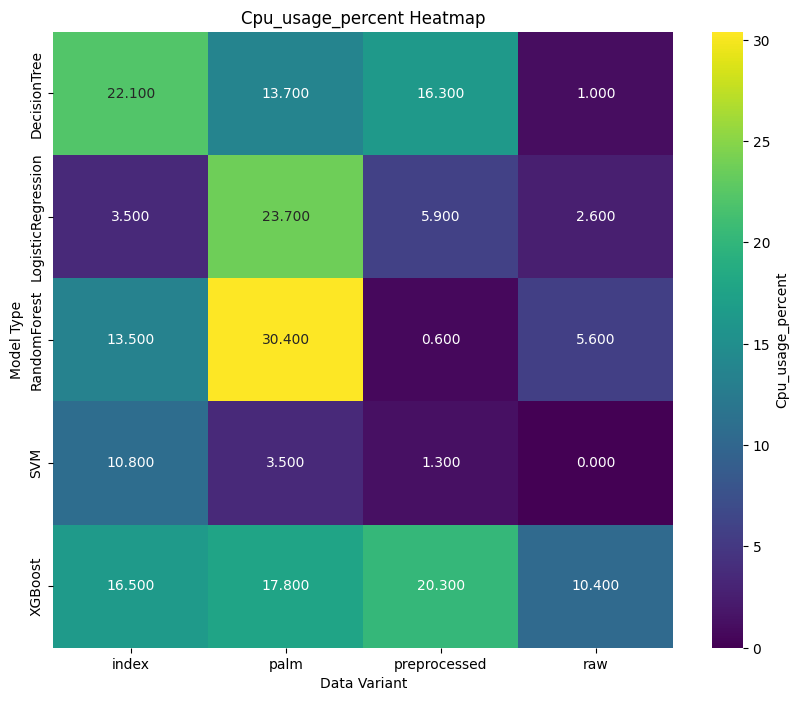

In [51]:
plot_metric_heatmap(metrics_df, metric_key="cpu_usage_percent")

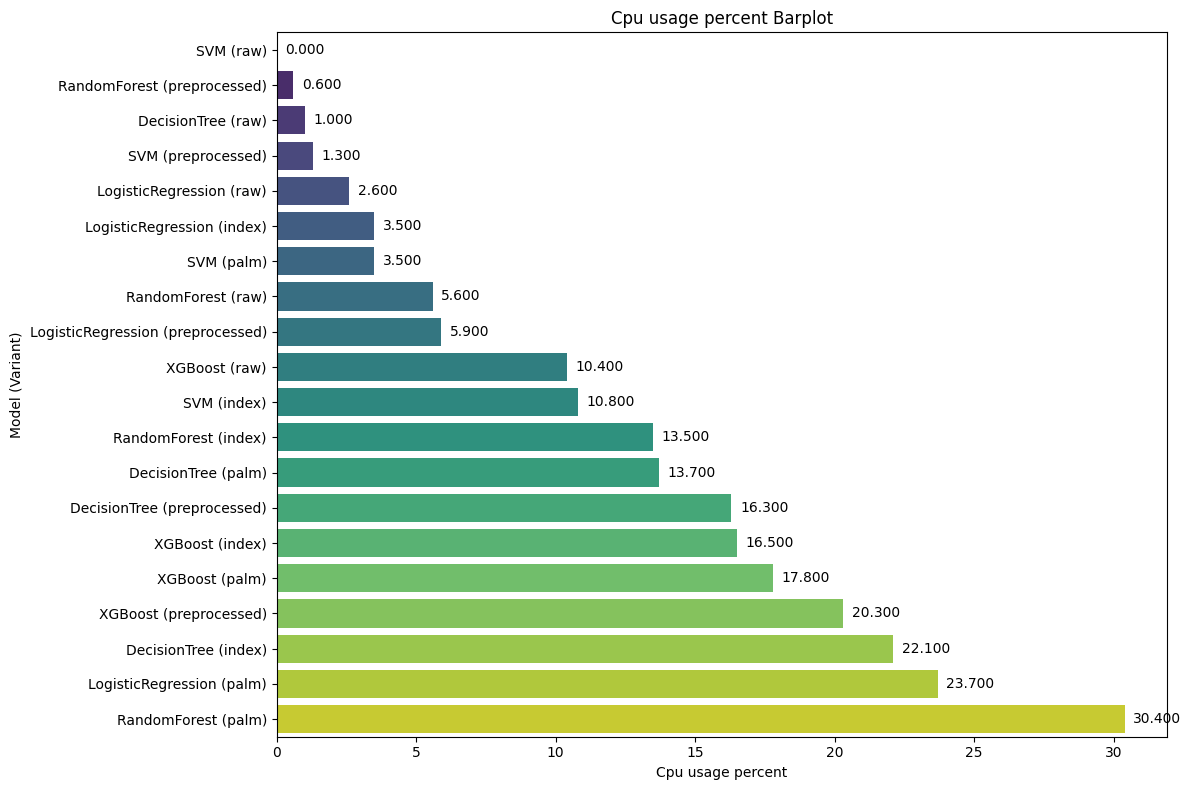

In [52]:
plot_metric_barplot(metrics_df, metric_key="cpu_usage_percent", ascending=True)

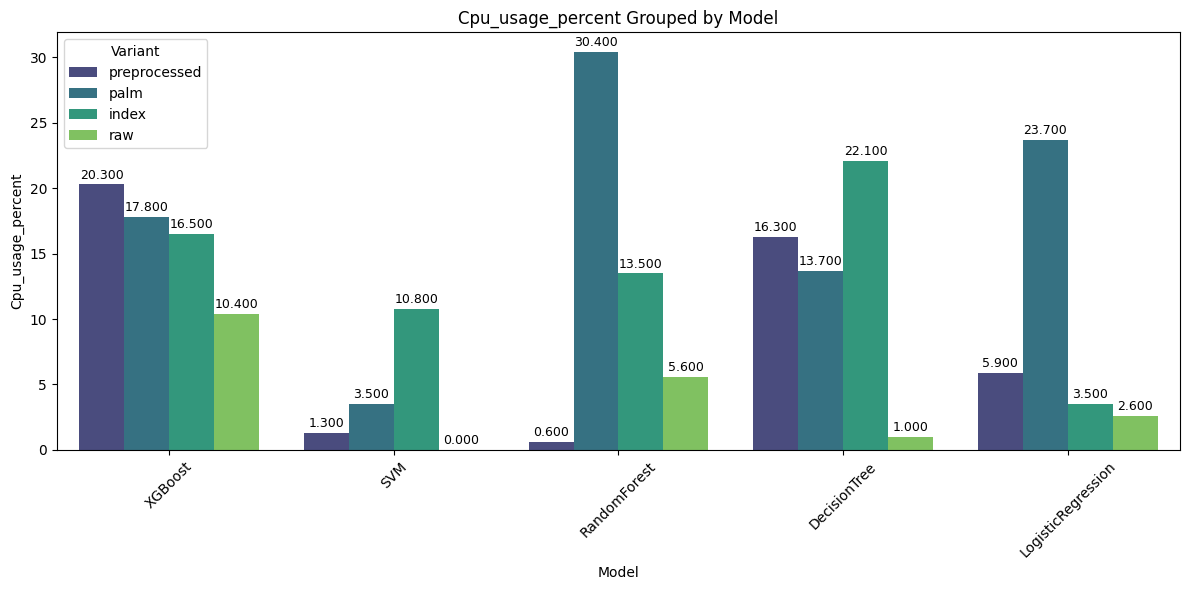

In [53]:
plot_grouped_barplot(metrics_df, metric_key="cpu_usage_percent", group_by="Model")

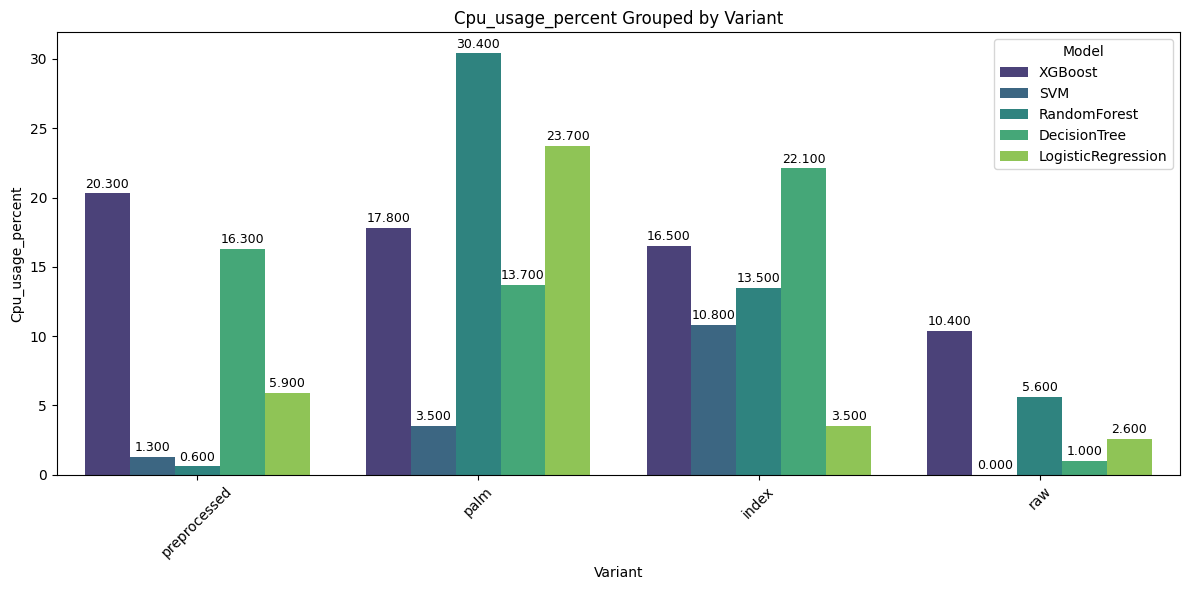

In [54]:
plot_grouped_barplot(metrics_df, metric_key="cpu_usage_percent", group_by="Variant")

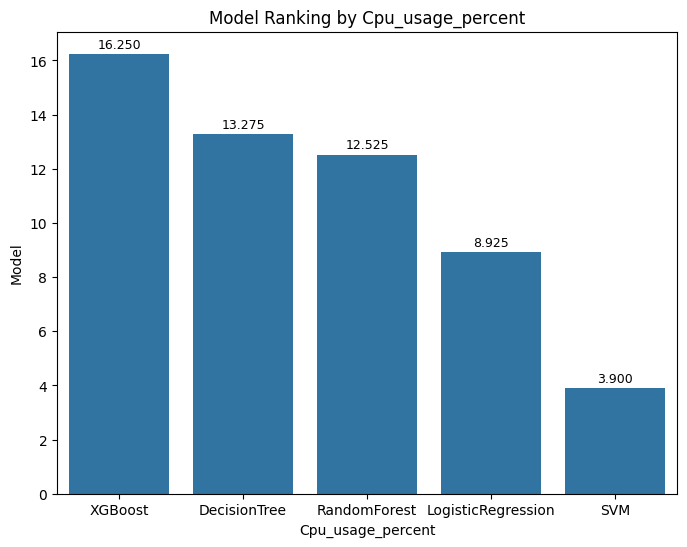

In [55]:
plot_model_ranking(metrics_df, metric_key="cpu_usage_percent", group_by="Model")

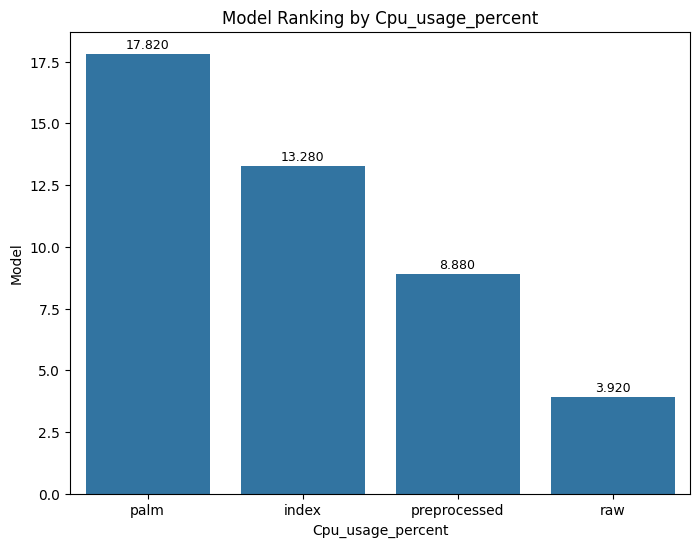

In [56]:
plot_model_ranking(metrics_df, metric_key="cpu_usage_percent", group_by="Variant")

Here the XGBoost has one of the highest CPU usage, which make it consumes a lot of CPU, while the SVM has the lowest CPU usage, which makes it a great candidate for the application where the CPU is limited like embedded systems.Also in most variants of random forest it has a low CPU usage, same goes for logstic regression.

For the different variants of the datasets, it seems that the raw is the one that consumes less than the other types, whule the palm has the highest avergae CPU usage accross the 4 variants

## Conclusion
After analyzing the results, we selected XGBoost (preprocessed) as the best model to use with our MediaPipe gesture prediction system, primarily due to its highest accuracy and F1-score. While it comes with a higher CPU usage (20.3%), it significantly outperforms other models in inference speed, achieving predictions in around 87 milliseconds, making it ideal for real-time classification.

Although SVM (preprocessed) showed similar performance in terms of accuracy and F1-score, its inference time exceeded 2 seconds, making it less suitable for live predictions. However, if CPU efficiency were the main priority, SVM (preprocessed) would have been a better choice, consuming only 1.3% CPU compared to XGBoost's usage.

For embedded systems, we recommend RandomForest (preprocessed). It offers a strong balance between performance and efficiency, with a moderate CPU usage (0.6%), inference time around 207 milliseconds, and high accuracy (0.97). It serves as a middle ground between the performance of XGBoost and the efficiency of SVM.

In a web-based application, we suggest using XGBoost (palm), which provides near-identical accuracy to XGBoost (preprocessed) but with reduced CPU usage (17.8%) and a slightly faster inference time 80 milliseconds, making it more suitable for scalable, cloud-hosted environments.

Finally, for quick testing or exploratory data analysis, DecisionTree (preprocessed) is recommended. It trains in seconds and delivers an accuracy of around 0.94, making it ideal for demonstration or prototyping purposes.

# MediaPipe

We merge the XGBoost model by the MediaPipe, to have our final model, we use opencv to load the video, and then we deal with it using Mediapipe

In [71]:
model_path = r'outputs\XGBoost\preprocessed\best_model.pkl'
with open(model_path, "rb") as f:
    model_handgesture_detection = pickle.load(f)

In [72]:
INPUT_VIDEO = "input_video.mp4"
OUTPUT_VIDEO = "output_video.mp4"

In [73]:
WINDOW_SIZE = 15
HAND_COLOR = (255, 0, 0)
MAX_HANDS = 2

In [74]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=MAX_HANDS)
detector = vision.HandLandmarker.create_from_options(options)

In [75]:
cap = cv2.VideoCapture(INPUT_VIDEO)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

In [76]:
prediction_history = {i: deque(maxlen=WINDOW_SIZE) for i in range(MAX_HANDS)}
blue_hand_style = mp.solutions.drawing_styles.DrawingSpec(
    color=HAND_COLOR, thickness=2)
blue_connection_style = mp.solutions.drawing_styles.DrawingSpec(
    color=HAND_COLOR, thickness=2)

In [77]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
    detection_result = detector.detect(mp_image)
    
    current_gestures = [None] * MAX_HANDS
    
    if detection_result.hand_landmarks:
        for hand_idx, landmarks in enumerate(detection_result.hand_landmarks[:MAX_HANDS]):
            data = {'label': ['dummy']}
            for i in range(21):
                data[f'x{i+1}'] = [landmarks[i].x * width]
                data[f'y{i+1}'] = [landmarks[i].y * height]
            
            df = pd.DataFrame(data)
            processed_df = preprocess_hand_landmarks(
                df,
                img_width=width,
                img_height=height,
                num_points=21,
                palm_idx=1,
                index_tip_idx=13
            )
            
            features = []
            for i in range(1, 22):
                features.append(processed_df[f'x{i}'].values[0])
                features.append(processed_df[f'y{i}'].values[0])
            
            pred = model_handgesture_detection.predict([features])[0]
            current_gestures[hand_idx] = pred
            prediction_history[hand_idx].append(pred)
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) 
                for lm in landmarks
            ])
            
            mp.solutions.drawing_utils.draw_landmarks(
                frame,
                hand_landmarks_proto,
                mp.solutions.hands.HAND_CONNECTIONS,
                blue_hand_style,
                blue_connection_style)
    
    stabilized_preds = []
    for hand_idx in range(MAX_HANDS):
        if len(prediction_history[hand_idx]) > 0:
            try:
                mode_result = stats.mode(prediction_history[hand_idx])
                stabilized_pred = mode_result.mode
                if isinstance(stabilized_pred, (np.ndarray, list)):
                    stabilized_pred = stabilized_pred[0]
                stabilized_preds.append(stabilized_pred)
            except:
                if current_gestures[hand_idx] is not None:
                    stabilized_preds.append(current_gestures[hand_idx])
    
    for hand_idx, pred in enumerate(stabilized_preds[:MAX_HANDS]):
        gesture_name = le.inverse_transform([pred])[0]
        cv2.putText(frame, f"Hand {hand_idx+1}: {gesture_name}",
                   (25, 25 + hand_idx * 40),
                   cv2.FONT_HERSHEY_SIMPLEX, 
                   1, 
                   (255, 255, 0), 4)
    
    out.write(frame)

cap.release()
out.release()